In [1]:
import gc
import os

import lightgbm as lgb
import numpy as np
import pandas as pd
import warnings

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.metrics import mean_squared_error
import graphviz
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import randint as sp_randint 
from sklearn.model_selection import train_test_split


import tqdm.autonotebook as tqdm
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

C:\Program Files\Anaconda3\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
# All those csvs have been shifted properly 
df_snp500 = reduce_mem_usage(pd.read_csv('FinalTimeShift_lowercase.csv'))
df_raw_oil = reduce_mem_usage(pd.read_csv('raw_oil_daily_shifted.csv'))
df_post_oil = reduce_mem_usage(pd.read_csv('post_oil_daily_shifted.csv'))
df_gold = reduce_mem_usage(pd.read_csv('au_daily_shifted.csv'))
df_yield_rate = reduce_mem_usage(pd.read_csv('yield_curve_daily_shifted.csv'))

df_snp500.head()
gc.collect()

Mem. usage decreased to 557.03 Mb (51.0% reduction)
Mem. usage decreased to  0.03 Mb (49.9% reduction)
Mem. usage decreased to  0.03 Mb (49.9% reduction)
Mem. usage decreased to  0.20 Mb (10.7% reduction)
Mem. usage decreased to  0.06 Mb (60.0% reduction)


245

In [4]:
# Calculate Percentage
df_snp500.drop(columns = ['Unnamed: 0'],inplace=True)
target = pd.DataFrame({'hourly_diff_perc':np.divide(np.subtract(df_snp500.unshift_close, df_snp500.close),df_snp500.close)})
df_snp500 = pd.concat([df_snp500,target],axis=1)
df_snp500.head()

,index,ticker,datetime,dtshift,open,high,low,close,volume,num_of_trades,...,unshift_open,unshift_high,unshift_low,unshift_close,unshift_volume,unshift_num_of_trades,unshift_weight_avg_price,unshift_difference,date,hourly_diff_perc
0,2,AAPL,2004.01.23 11:00:00,2004.01.23 10:00:00,3.199219,3.250000,3.230469,3.199219,46228.0,1642.0,...,3.230469,3.230469,3.230469,3.210938,32627,1075,3.222656,-0.020004,2004.01.23,0.003662
1,3,AAPL,2004.01.23 12:00:00,2004.01.23 11:00:00,3.230469,3.230469,3.230469,3.210938,32627.0,1075.0,...,3.230469,3.240234,3.220703,3.210938,40201,1456,3.228516,-0.020004,2004.01.23,0.000000
2,4,AAPL,2004.01.23 13:00:00,2004.01.23 12:00:00,3.230469,3.240234,3.220703,3.210938,40201.0,1456.0,...,3.220703,3.230469,3.210938,3.210938,14798,778,3.218750,-0.010002,2004.01.23,0.000000
3,5,AAPL,2004.01.23 14:00:00,2004.01.23 13:00:00,3.220703,3.230469,3.210938,3.210938,14798.0,778.0,...,3.210938,3.220703,3.210938,3.199219,29540,1014,3.212891,-0.010002,2004.01.23,-0.003649
4,9,AAPL,2004.01.26 11:00:00,2004.01.26 10:00:00,3.240234,3.250000,3.240234,3.220703,52325.0,1872.0,...,3.240234,3.259766,3.250000,3.240234,42224,1211,3.250000,0.000000,2004.01.26,0.006065


In [5]:
# Drop Useless columns 
df_snp500.drop(columns=[ 'difference','unshift_open', 'unshift_high',
       'unshift_low', 'unshift_close', 'unshift_volume',
       'unshift_num_of_trades', 'unshift_weight_avg_price',
       'unshift_difference','datetime_t','dtshift_t','date'],inplace=True)
df_snp500

,index,ticker,datetime,dtshift,open,high,low,close,volume,num_of_trades,weight_avg_price,hourly_diff_perc
0,2,AAPL,2004.01.23 11:00:00,2004.01.23 10:00:00,3.199219,3.250000,3.230469,3.199219,46228.0,1642.0,3.232422,0.003662
1,3,AAPL,2004.01.23 12:00:00,2004.01.23 11:00:00,3.230469,3.230469,3.230469,3.210938,32627.0,1075.0,3.222656,0.000000
2,4,AAPL,2004.01.23 13:00:00,2004.01.23 12:00:00,3.230469,3.240234,3.220703,3.210938,40201.0,1456.0,3.228516,0.000000
3,5,AAPL,2004.01.23 14:00:00,2004.01.23 13:00:00,3.220703,3.230469,3.210938,3.210938,14798.0,778.0,3.218750,-0.003649
4,9,AAPL,2004.01.26 11:00:00,2004.01.26 10:00:00,3.240234,3.250000,3.240234,3.220703,52325.0,1872.0,3.234375,0.006065
5,10,AAPL,2004.01.26 12:00:00,2004.01.26 11:00:00,3.240234,3.259766,3.250000,3.240234,42224.0,1211.0,3.250000,0.003014
6,11,AAPL,2004.01.26 13:00:00,2004.01.26 12:00:00,3.250000,3.279297,3.250000,3.250000,31941.0,1175.0,3.263672,0.000000
7,12,AAPL,2004.01.26 14:00:00,2004.01.26 13:00:00,3.250000,3.269531,3.269531,3.250000,27685.0,888.0,3.265625,0.003004
8,16,AAPL,2004.01.27 11:00:00,2004.01.27 10:00:00,3.289062,3.310547,3.279297,3.259766,53935.0,1521.0,3.287109,0.002996
9,17,AAPL,2004.01.27 12:00:00,2004.01.27 11:00:00,3.279297,3.289062,3.289062,3.269531,41958.0,1278.0,3.279297,0.000000


In [8]:
# Datetime type cast
df_snp500.datetime = pd.DataFrame({'dateimte':pd.to_datetime(df_snp500.datetime)})
df_snp500['date'] = df_snp500.datetime.dt.date
df_snp500.head()

,index,ticker,datetime,dtshift,open,high,low,close,volume,num_of_trades,weight_avg_price,hourly_diff_perc,date
0,2,AAPL,2004-01-23 11:00:00,2004.01.23 10:00:00,3.199219,3.250000,3.230469,3.199219,46228.0,1642.0,3.232422,0.003662,2004-01-23
1,3,AAPL,2004-01-23 12:00:00,2004.01.23 11:00:00,3.230469,3.230469,3.230469,3.210938,32627.0,1075.0,3.222656,0.000000,2004-01-23
2,4,AAPL,2004-01-23 13:00:00,2004.01.23 12:00:00,3.230469,3.240234,3.220703,3.210938,40201.0,1456.0,3.228516,0.000000,2004-01-23
3,5,AAPL,2004-01-23 14:00:00,2004.01.23 13:00:00,3.220703,3.230469,3.210938,3.210938,14798.0,778.0,3.218750,-0.003649,2004-01-23
4,9,AAPL,2004-01-26 11:00:00,2004.01.26 10:00:00,3.240234,3.250000,3.240234,3.220703,52325.0,1872.0,3.234375,0.006065,2004-01-26


In [9]:
# create datetime on all
df_gold['date'] = pd.DataFrame({'date':pd.to_datetime(df_gold.date)})
df_yield_rate['date']= pd.DataFrame({'date':pd.to_datetime(df_yield_rate.date)})
df_post_oil['date'] = pd.DataFrame({'date':pd.to_datetime(df_post_oil.date)})
df_raw_oil['date'] = pd.DataFrame({'date':pd.to_datetime(df_raw_oil.date)})
df_gold.drop(columns=['Unnamed: 0'],inplace=True)
df_raw_oil.drop(columns=['Unnamed: 0'],inplace=True)
df_post_oil.drop(columns=['Unnamed: 0'],inplace=True)
df_yield_rate.drop(columns=['Unnamed: 0'],inplace=True)

In [10]:
# create merge references
def create_year_month_day(df_au):
    try:
        df_au['year'] = df_au.datetime.dt.year
        df_au['month'] = df_au.datetime.dt.month
        df_au['day'] = df_au.datetime.dt.day
    except:
        df_au['year'] = df_au.date.dt.year
        df_au['month'] = df_au.date.dt.month
        df_au['day'] = df_au.date.dt.day
        print(df_au.head())
    return df_au

In [11]:
# run those functions
df_gold = create_year_month_day(df_gold)
df_yield_rate = create_year_month_day(df_yield_rate)
df_post_oil = create_year_month_day(df_post_oil)
df_raw_oil = create_year_month_day(df_raw_oil)

        date  au_price   au_open   au_high    au_low au_change_percent  year  \
0 2019-11-22  1,465.16  1,474.62  1,475.70  1,462.51            -0.63%  2019   
1 2019-11-21  1,474.51  1,474.62  1,478.90  1,466.09            -0.00%  2019   
2 2019-11-20  1,474.52  1,471.72  1,475.50  1,464.95             0.19%  2019   
3 2019-11-19  1,471.79  1,469.12  1,473.98  1,456.45             0.30%  2019   
4 2019-11-18  1,467.37  1,469.43  1,469.95  1,462.49            -0.13%  2019   

   month  day  
0     11   22  
1     11   21  
2     11   20  
3     11   19  
4     11   18  
        date      2_yr     10_yr  30_yr  year  month  day
0 2004-01-05  1.940430  4.378906    NaN  2004      1    5
1 2004-01-06  1.950195  4.410156    NaN  2004      1    6
2 2004-01-07  1.839844  4.289062    NaN  2004      1    7
3 2004-01-08  1.839844  4.269531    NaN  2004      1    8
4 2004-01-09  1.849609  4.269531    NaN  2004      1    9
        date  post_oil  year  month  day
0 2009-11-25   75.3750  2009     1

In [12]:
df_snp500 = create_year_month_day(df_snp500)
df_snp500.head()

,index,ticker,datetime,dtshift,open,high,low,close,volume,num_of_trades,weight_avg_price,hourly_diff_perc,date,year,month,day
0,2,AAPL,2004-01-23 11:00:00,2004.01.23 10:00:00,3.199219,3.250000,3.230469,3.199219,46228.0,1642.0,3.232422,0.003662,2004-01-23,2004,1,23
1,3,AAPL,2004-01-23 12:00:00,2004.01.23 11:00:00,3.230469,3.230469,3.230469,3.210938,32627.0,1075.0,3.222656,0.000000,2004-01-23,2004,1,23
2,4,AAPL,2004-01-23 13:00:00,2004.01.23 12:00:00,3.230469,3.240234,3.220703,3.210938,40201.0,1456.0,3.228516,0.000000,2004-01-23,2004,1,23
3,5,AAPL,2004-01-23 14:00:00,2004.01.23 13:00:00,3.220703,3.230469,3.210938,3.210938,14798.0,778.0,3.218750,-0.003649,2004-01-23,2004,1,23
4,9,AAPL,2004-01-26 11:00:00,2004.01.26 10:00:00,3.240234,3.250000,3.240234,3.220703,52325.0,1872.0,3.234375,0.006065,2004-01-26,2004,1,26


In [13]:
# merge to a big df
df_train = df_snp500.merge(df_gold, on=['year','month','day'], how="left")
df_train = df_train.merge(df_raw_oil, on=['year','month','day'], how="left")
df_train = df_train.merge(df_post_oil, on=['year','month','day'], how="left")
df_train = df_train.merge(df_yield_rate, on=['year','month','day'], how="left")
df_train.head()

,index,ticker,datetime,dtshift,open,high,low,close,volume,num_of_trades,...,au_low,au_change_percent,date_x,raw_oil,date_y,post_oil,date,2_yr,10_yr,30_yr
0,2,AAPL,2004-01-23 11:00:00,2004.01.23 10:00:00,3.199219,3.250000,3.230469,3.199219,46228.0,1642.0,...,409.25,-0.26%,NaT,NaN,NaT,NaN,2004-01-23,1.660156,3.990234,NaN
1,3,AAPL,2004-01-23 12:00:00,2004.01.23 11:00:00,3.230469,3.230469,3.230469,3.210938,32627.0,1075.0,...,409.25,-0.26%,NaT,NaN,NaT,NaN,2004-01-23,1.660156,3.990234,NaN
2,4,AAPL,2004-01-23 13:00:00,2004.01.23 12:00:00,3.230469,3.240234,3.220703,3.210938,40201.0,1456.0,...,409.25,-0.26%,NaT,NaN,NaT,NaN,2004-01-23,1.660156,3.990234,NaN
3,5,AAPL,2004-01-23 14:00:00,2004.01.23 13:00:00,3.220703,3.230469,3.210938,3.210938,14798.0,778.0,...,409.25,-0.26%,NaT,NaN,NaT,NaN,2004-01-23,1.660156,3.990234,NaN
4,9,AAPL,2004-01-26 11:00:00,2004.01.26 10:00:00,3.240234,3.250000,3.240234,3.220703,52325.0,1872.0,...,407.80,-0.35%,NaT,NaN,NaT,NaN,2004-01-26,1.709961,4.089844,NaN


In [14]:
# Check missing percentage of the df_train
total = df_train.isnull().sum().sort_values(ascending=False)
percent=(df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
miss_percent = pd.concat([total,percent],axis=1,keys=['total','percent'])
miss_percent

,total,percent
post_oil,2246583,0.361551
date_y,2246583,0.361551
raw_oil,2224705,0.358030
date_x,2224705,0.358030
30_yr,782820,0.125982
2_yr,46639,0.007506
10_yr,46639,0.007506
date,44999,0.007242
high,0,0.000000
volume,0,0.000000


In [15]:
df_train.drop(columns=['date_x','date_y','date','dtshift'],inplace=True)
df_train

,index,ticker,datetime,open,high,low,close,volume,num_of_trades,weight_avg_price,...,au_price,au_open,au_high,au_low,au_change_percent,raw_oil,post_oil,2_yr,10_yr,30_yr
0,2,AAPL,2004-01-23 11:00:00,3.199219,3.250000,3.230469,3.199219,46228.0,1642.0,3.232422,...,409.62,410.60,409.62,409.25,-0.26%,NaN,NaN,1.660156,3.990234,NaN
1,3,AAPL,2004-01-23 12:00:00,3.230469,3.230469,3.230469,3.210938,32627.0,1075.0,3.222656,...,409.62,410.60,409.62,409.25,-0.26%,NaN,NaN,1.660156,3.990234,NaN
2,4,AAPL,2004-01-23 13:00:00,3.230469,3.240234,3.220703,3.210938,40201.0,1456.0,3.228516,...,409.62,410.60,409.62,409.25,-0.26%,NaN,NaN,1.660156,3.990234,NaN
3,5,AAPL,2004-01-23 14:00:00,3.220703,3.230469,3.210938,3.210938,14798.0,778.0,3.218750,...,409.62,410.60,409.62,409.25,-0.26%,NaN,NaN,1.660156,3.990234,NaN
4,9,AAPL,2004-01-26 11:00:00,3.240234,3.250000,3.240234,3.220703,52325.0,1872.0,3.234375,...,408.18,409.75,408.18,407.80,-0.35%,NaN,NaN,1.709961,4.089844,NaN
5,10,AAPL,2004-01-26 12:00:00,3.240234,3.259766,3.250000,3.240234,42224.0,1211.0,3.250000,...,408.18,409.75,408.18,407.80,-0.35%,NaN,NaN,1.709961,4.089844,NaN
6,11,AAPL,2004-01-26 13:00:00,3.250000,3.279297,3.250000,3.250000,31941.0,1175.0,3.263672,...,408.18,409.75,408.18,407.80,-0.35%,NaN,NaN,1.709961,4.089844,NaN
7,12,AAPL,2004-01-26 14:00:00,3.250000,3.269531,3.269531,3.250000,27685.0,888.0,3.265625,...,408.18,409.75,408.18,407.80,-0.35%,NaN,NaN,1.709961,4.089844,NaN
8,16,AAPL,2004-01-27 11:00:00,3.289062,3.310547,3.279297,3.259766,53935.0,1521.0,3.287109,...,403.88,407.25,403.88,403.50,-1.05%,NaN,NaN,1.750000,4.160156,NaN
9,17,AAPL,2004-01-27 12:00:00,3.279297,3.289062,3.289062,3.269531,41958.0,1278.0,3.279297,...,403.88,407.25,403.88,403.50,-1.05%,NaN,NaN,1.750000,4.160156,NaN


# interpolation method/ Imputation method? Mice? Knn?
# Here I just drop na

In [16]:
# Use joblib to save label encoder references 

import joblib
categoricals = ['ticker']
target = pd.DataFrame({'DIFF':df_train['hourly_diff_perc']})
categorical_df = df_train[categoricals]
continuous_df = df_train.drop(columns=['hourly_diff_perc','ticker'])
le = LabelEncoder()
LabelEncoder = le.fit(df_train['ticker'])
integer_mapping = {l: i for i, l in enumerate(le.classes_)}
joblib.dump(df_train['ticker'],'df_train_ticker')
le = LabelEncoder.transform(df_train['ticker'])
le = pd.DataFrame({'ticker_le':le})

categorical_df = pd.concat([categorical_df, le],axis=1)
categorical_df.drop(['ticker'],inplace=True,axis=1)
columns_data =categorical_df.columns
categorical_df.head()
df_train = pd.concat([continuous_df,categorical_df,target],axis=1)
df_train_columns = df_train.columns
df_train.head()


,index,datetime,open,high,low,close,volume,num_of_trades,weight_avg_price,year,...,au_high,au_low,au_change_percent,raw_oil,post_oil,2_yr,10_yr,30_yr,ticker_le,DIFF
0,2,2004-01-23 11:00:00,3.199219,3.250000,3.230469,3.199219,46228.0,1642.0,3.232422,2004,...,409.62,409.25,-0.26%,NaN,NaN,1.660156,3.990234,NaN,2,0.003662
1,3,2004-01-23 12:00:00,3.230469,3.230469,3.230469,3.210938,32627.0,1075.0,3.222656,2004,...,409.62,409.25,-0.26%,NaN,NaN,1.660156,3.990234,NaN,2,0.000000
2,4,2004-01-23 13:00:00,3.230469,3.240234,3.220703,3.210938,40201.0,1456.0,3.228516,2004,...,409.62,409.25,-0.26%,NaN,NaN,1.660156,3.990234,NaN,2,0.000000
3,5,2004-01-23 14:00:00,3.220703,3.230469,3.210938,3.210938,14798.0,778.0,3.218750,2004,...,409.62,409.25,-0.26%,NaN,NaN,1.660156,3.990234,NaN,2,-0.003649
4,9,2004-01-26 11:00:00,3.240234,3.250000,3.240234,3.220703,52325.0,1872.0,3.234375,2004,...,408.18,407.80,-0.35%,NaN,NaN,1.709961,4.089844,NaN,2,0.006065


In [17]:
# take a look at mappings 
integer_mapping

{'A': 0,
 'AAP': 1,
 'AAPL': 2,
 'ABBV': 3,
 'ABC': 4,
 'ABT': 5,
 'ACN': 6,
 'ADBE': 7,
 'ADI': 8,
 'ADM': 9,
 'ADP': 10,
 'ADS': 11,
 'ADSK': 12,
 'AEE': 13,
 'AEP': 14,
 'AES': 15,
 'AFL': 16,
 'AGN': 17,
 'AIG': 18,
 'AIV': 19,
 'AIZ': 20,
 'AJG': 21,
 'AKAM': 22,
 'ALB': 23,
 'ALGN': 24,
 'ALK': 25,
 'ALL': 26,
 'ALLE': 27,
 'ALXN': 28,
 'AMAT': 29,
 'AMD': 30,
 'AME': 31,
 'AMG': 32,
 'AMGN': 33,
 'AMP': 34,
 'AMT': 35,
 'AMZN': 36,
 'ANSS': 37,
 'ANTM': 38,
 'AON': 39,
 'AOS': 40,
 'APA': 41,
 'APC': 42,
 'APD': 43,
 'APH': 44,
 'APTV': 45,
 'ARE': 46,
 'ARNC': 47,
 'ATVI': 48,
 'AVB': 49,
 'AVGO': 50,
 'AVY': 51,
 'AWK': 52,
 'AXP': 53,
 'AZO': 54,
 'BA': 55,
 'BAC': 56,
 'BAX': 57,
 'BBT': 58,
 'BBY': 59,
 'BDX': 60,
 'BEN': 61,
 'BHF': 62,
 'BHGE': 63,
 'BIIB': 64,
 'BK': 65,
 'BKNG': 66,
 'BLK': 67,
 'BLL': 68,
 'BMY': 69,
 'BSX': 70,
 'BWA': 71,
 'BXP': 72,
 'C': 73,
 'CAG': 74,
 'CAH': 75,
 'CAT': 76,
 'CB': 77,
 'CBOE': 78,
 'CBRE': 79,
 'CBS': 80,
 'CCI': 81,
 'CCL': 82,

In [ ]:
# get rid of id's
df_train.drop(columns = ['index'],inplace = True)

In [ ]:
df_train

In [18]:
# actually we don't have any categoricals
categorical_features = [
    "ticker_le"
]
all_features = [col for col in df_train.columns if col not in ["datetime", 'DIFF','']]
df_train = df_train.rename(columns = {"datetime": "timestamp"})
df_train.head()

,index,timestamp,open,high,low,close,volume,num_of_trades,weight_avg_price,year,...,au_high,au_low,au_change_percent,raw_oil,post_oil,2_yr,10_yr,30_yr,ticker_le,DIFF
0,2,2004-01-23 11:00:00,3.199219,3.250000,3.230469,3.199219,46228.0,1642.0,3.232422,2004,...,409.62,409.25,-0.26%,NaN,NaN,1.660156,3.990234,NaN,2,0.003662
1,3,2004-01-23 12:00:00,3.230469,3.230469,3.230469,3.210938,32627.0,1075.0,3.222656,2004,...,409.62,409.25,-0.26%,NaN,NaN,1.660156,3.990234,NaN,2,0.000000
2,4,2004-01-23 13:00:00,3.230469,3.240234,3.220703,3.210938,40201.0,1456.0,3.228516,2004,...,409.62,409.25,-0.26%,NaN,NaN,1.660156,3.990234,NaN,2,0.000000
3,5,2004-01-23 14:00:00,3.220703,3.230469,3.210938,3.210938,14798.0,778.0,3.218750,2004,...,409.62,409.25,-0.26%,NaN,NaN,1.660156,3.990234,NaN,2,-0.003649
4,9,2004-01-26 11:00:00,3.240234,3.250000,3.240234,3.220703,52325.0,1872.0,3.234375,2004,...,408.18,407.80,-0.35%,NaN,NaN,1.709961,4.089844,NaN,2,0.006065


In [19]:
# functions for lag features, but, not used lol
def create_lag_features(df, window):
    """
    Creating lag-based features looking back in time.
    """
    
    feature_cols = ["VOLUME", "NUMBER OF TRADES"]
    df_site = df.groupby("TICKER_LE")
    
    df_rolled = df_site[feature_cols].rolling(window=window, min_periods=0)
    
    df_mean = df_rolled.mean().reset_index().astype(np.float16)
    df_median = df_rolled.median().reset_index().astype(np.float16)
    df_min = df_rolled.min().reset_index().astype(np.float16)
    df_max = df_rolled.max().reset_index().astype(np.float16)
    df_std = df_rolled.std().reset_index().astype(np.float16)
    df_skew = df_rolled.skew().reset_index().astype(np.float16)
    
    for feature in feature_cols:
        df[f"{feature}_mean_lag{window}"] = df_mean[feature]
        df[f"{feature}_median_lag{window}"] = df_median[feature]
        df[f"{feature}_min_lag{window}"] = df_min[feature]
        df[f"{feature}_max_lag{window}"] = df_max[feature]
        df[f"{feature}_std_lag{window}"] = df_std[feature]
        df[f"{feature}_skew_lag{window}"] = df_std[feature]
        
    return df

In [20]:
#df_train['au_price'] = df_train['au_price'].astype(float)
# df_train['au_open'] = df_train['au_open'].astype(float)
# df_train['au_high'] = df_train['au_high'].astype(float)
# df_train['au_low'] = df_train['au_low'].astype(float)
# df_train['au_change_percent'] = df_train['au_change_percent'].astype(float)
# df_train.dtypes

df_train.drop(columns=['au_price', 'au_open', 'au_high', 'au_low', 'au_change_percent'],inplace = True)

#I can only drop it since the data is probamatic

In [21]:
df_train['hour'] = df_train.timestamp.dt.hour
df_train.columns


Index(['index', 'timestamp', 'open', 'high', 'low', 'close', 'volume',
       'num_of_trades', 'weight_avg_price', 'year', 'month', 'day', 'raw_oil',
       'post_oil', '2_yr', '10_yr', '30_yr', 'ticker_le', 'DIFF', 'hour'],
      dtype='object')

In [22]:
df_train.describe()

,index,open,high,low,close,volume,num_of_trades,weight_avg_price,year,month,day,raw_oil,post_oil,2_yr,10_yr,30_yr,ticker_le,DIFF,hour
count,6.213735e+06,6.213735e+06,6.213735e+06,6.213735e+06,6.213735e+06,6.213735e+06,6.213735e+06,6.213735e+06,6.213735e+06,6.213735e+06,6.213735e+06,3.989030e+06,3.967152e+06,6.167096e+06,6.167096e+06,5.430915e+06,6.213735e+06,6.213735e+06,6.213735e+06
mean,4.254185e+03,NaN,NaN,NaN,NaN,6.360070e+03,2.335545e+03,NaN,2.011369e+03,6.568482e+00,1.573905e+01,NaN,NaN,NaN,NaN,NaN,2.311815e+02,1.722336e-03,1.249664e+01
std,2.539023e+03,NaN,NaN,NaN,NaN,2.040419e+04,4.097432e+03,NaN,4.279944e+00,3.412257e+00,8.745712e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.344248e+02,NaN,1.123089e+00
min,1.000000e+00,1.000214e-02,4.998779e-02,4.998779e-02,1.000214e-02,0.000000e+00,0.000000e+00,4.998779e-02,2.004000e+03,1.000000e+00,1.000000e+00,2.620312e+01,2.787500e+01,1.600342e-01,1.370117e+00,2.109375e+00,0.000000e+00,-1.000000e+00,4.000000e+00
25%,2.019000e+03,2.662500e+01,2.675000e+01,2.662500e+01,2.651562e+01,1.009000e+03,5.160000e+02,2.662500e+01,2.008000e+03,4.000000e+00,8.000000e+00,5.100000e+01,5.559375e+01,5.200195e-01,2.220703e+00,2.949219e+00,1.150000e+02,-1.622200e-03,1.100000e+01
50%,4.207000e+03,4.400000e+01,4.415625e+01,4.400000e+01,4.384375e+01,2.276000e+03,1.162000e+03,4.400000e+01,2.012000e+03,7.000000e+00,1.600000e+01,7.531250e+01,7.756250e+01,9.599609e-01,2.839844e+00,3.320312e+00,2.310000e+02,4.959106e-04,1.200000e+01
75%,6.447000e+03,7.131250e+01,7.156250e+01,7.131250e+01,7.112500e+01,5.382000e+03,2.599000e+03,7.131250e+01,2.015000e+03,1.000000e+01,2.300000e+01,9.450000e+01,1.083125e+02,2.580078e+00,3.910156e+00,4.371094e+00,3.480000e+02,2.555847e-03,1.300000e+01
max,9.326000e+03,2.212000e+03,1.000000e+04,2.212000e+03,2.208000e+03,4.240844e+06,4.848580e+05,2.214000e+03,2.019000e+03,1.200000e+01,3.100000e+01,1.133750e+02,1.281250e+02,5.289062e+00,5.261719e+00,5.351562e+00,4.670000e+02,5.328000e+03,1.900000e+01


In [23]:
df_train['site_id'] = df_train['ticker_le']
df_train.head()

,index,timestamp,open,high,low,close,volume,num_of_trades,weight_avg_price,year,...,day,raw_oil,post_oil,2_yr,10_yr,30_yr,ticker_le,DIFF,hour,site_id
0,2,2004-01-23 11:00:00,3.199219,3.250000,3.230469,3.199219,46228.0,1642.0,3.232422,2004,...,23,NaN,NaN,1.660156,3.990234,NaN,2,0.003662,11,2
1,3,2004-01-23 12:00:00,3.230469,3.230469,3.230469,3.210938,32627.0,1075.0,3.222656,2004,...,23,NaN,NaN,1.660156,3.990234,NaN,2,0.000000,12,2
2,4,2004-01-23 13:00:00,3.230469,3.240234,3.220703,3.210938,40201.0,1456.0,3.228516,2004,...,23,NaN,NaN,1.660156,3.990234,NaN,2,0.000000,13,2
3,5,2004-01-23 14:00:00,3.220703,3.230469,3.210938,3.210938,14798.0,778.0,3.218750,2004,...,23,NaN,NaN,1.660156,3.990234,NaN,2,-0.003649,14,2
4,9,2004-01-26 11:00:00,3.240234,3.250000,3.240234,3.220703,52325.0,1872.0,3.234375,2004,...,26,NaN,NaN,1.709961,4.089844,NaN,2,0.006065,11,2


In [24]:
X = df_train.drop(columns=['DIFF','timestamp','ticker_le','site_id'])
target = df_train['DIFF']

X, X_test, target, target_test = train_test_split(X, target, shuffle=True, test_size=0.5, random_state = 13)


In [25]:
# we didn't use this _hyperpara_
params = {"objective": "regression",
                  "num_leaves": 100,
                  'max_bin':1000,
                  "learning_rate": 0.01,
                  'num_iterations':1000,
                  'bagging_fraction':0.99,
                  'feature_fraction':0.9,
                  "metric": "rmse"
                  }

In [26]:
categoricals = ['ticker_le']

In [27]:
gc.collect()

939

3 fold CV for site_id: 2
Train Test loaded, shape and head
(16108, 20) (4028, 20)
   index      open      high       low     close   volume  num_of_trades  \
0      2  3.199219  3.250000  3.230469  3.199219  46228.0         1642.0   
1      3  3.230469  3.230469  3.230469  3.210938  32627.0         1075.0   
2      4  3.230469  3.240234  3.220703  3.210938  40201.0         1456.0   
3      5  3.220703  3.230469  3.210938  3.210938  14798.0          778.0   
4      9  3.240234  3.250000  3.240234  3.220703  52325.0         1872.0   
5     10  3.240234  3.259766  3.250000  3.240234  42224.0         1211.0   
6     11  3.250000  3.279297  3.250000  3.250000  31941.0         1175.0   
7     12  3.250000  3.269531  3.269531  3.250000  27685.0          888.0   
8     16  3.289062  3.310547  3.279297  3.259766  53935.0         1521.0   
9     17  3.279297  3.289062  3.289062  3.269531  41958.0         1278.0   

   weight_avg_price  year  month  day  raw_oil  post_oil      2_yr     10_yr  \
0

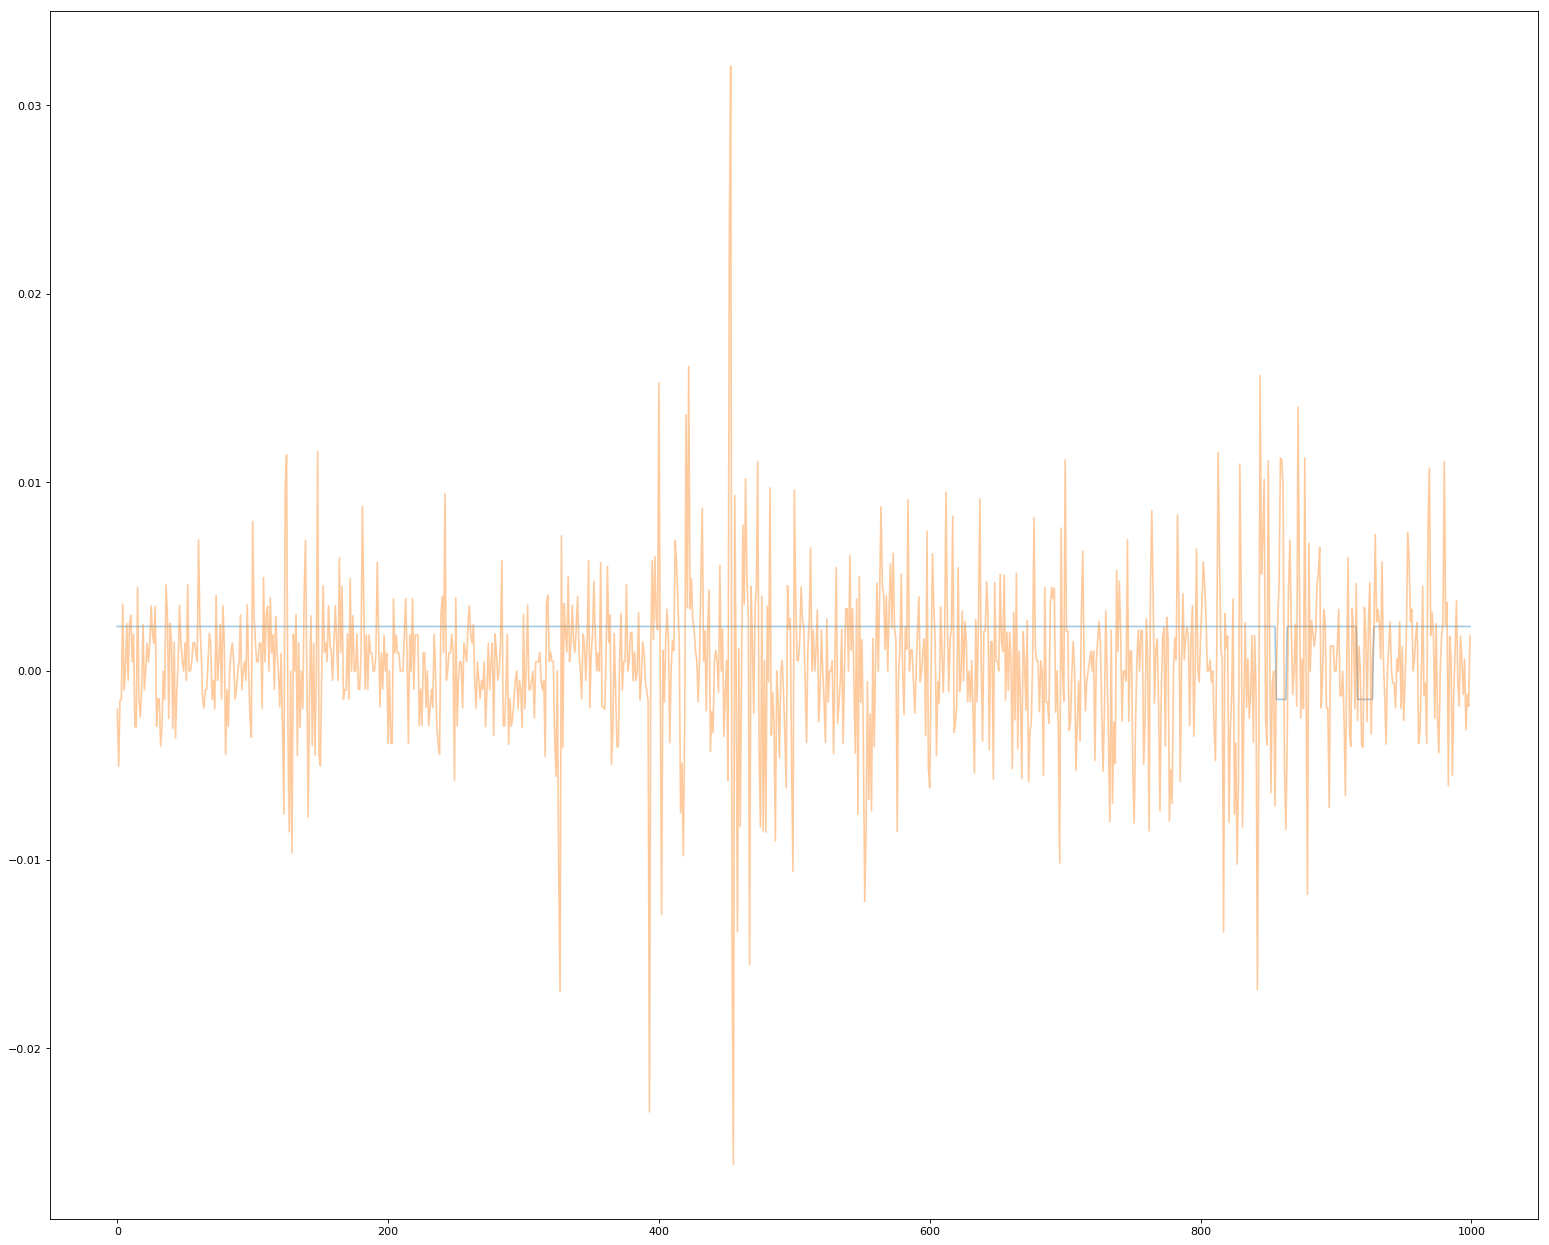

-------------------------------------------

Site Id: 2 , CV RMSE: 0.010983150369192198 

3 fold CV for site_id: 1
Train Test loaded, shape and head
(11984, 20) (2997, 20)
   index      open      high       low     close  volume  num_of_trades  \
0      2  41.78125  41.84375  41.84375  41.65625  1442.0          129.0   
1      3  41.84375  42.00000  41.78125  41.68750   728.0          111.0   
2      4  41.71875  41.81250  41.68750  41.62500   863.0           80.0   
3      5  41.65625  41.68750  41.59375  41.59375   233.0           61.0   
4      9  41.65625  41.71875  41.62500  41.53125   719.0          157.0   
5     10  41.62500  41.62500  41.09375  41.06250   549.0          135.0   
6     11  41.12500  41.25000  41.21875  40.90625   447.0          142.0   
7     12  41.18750  41.21875  41.21875  41.06250   584.0          111.0   
8     16  41.25000  41.31250  41.00000  41.00000   841.0          109.0   
9     17  41.00000  41.09375  40.93750  40.93750  1180.0           70.0   

  

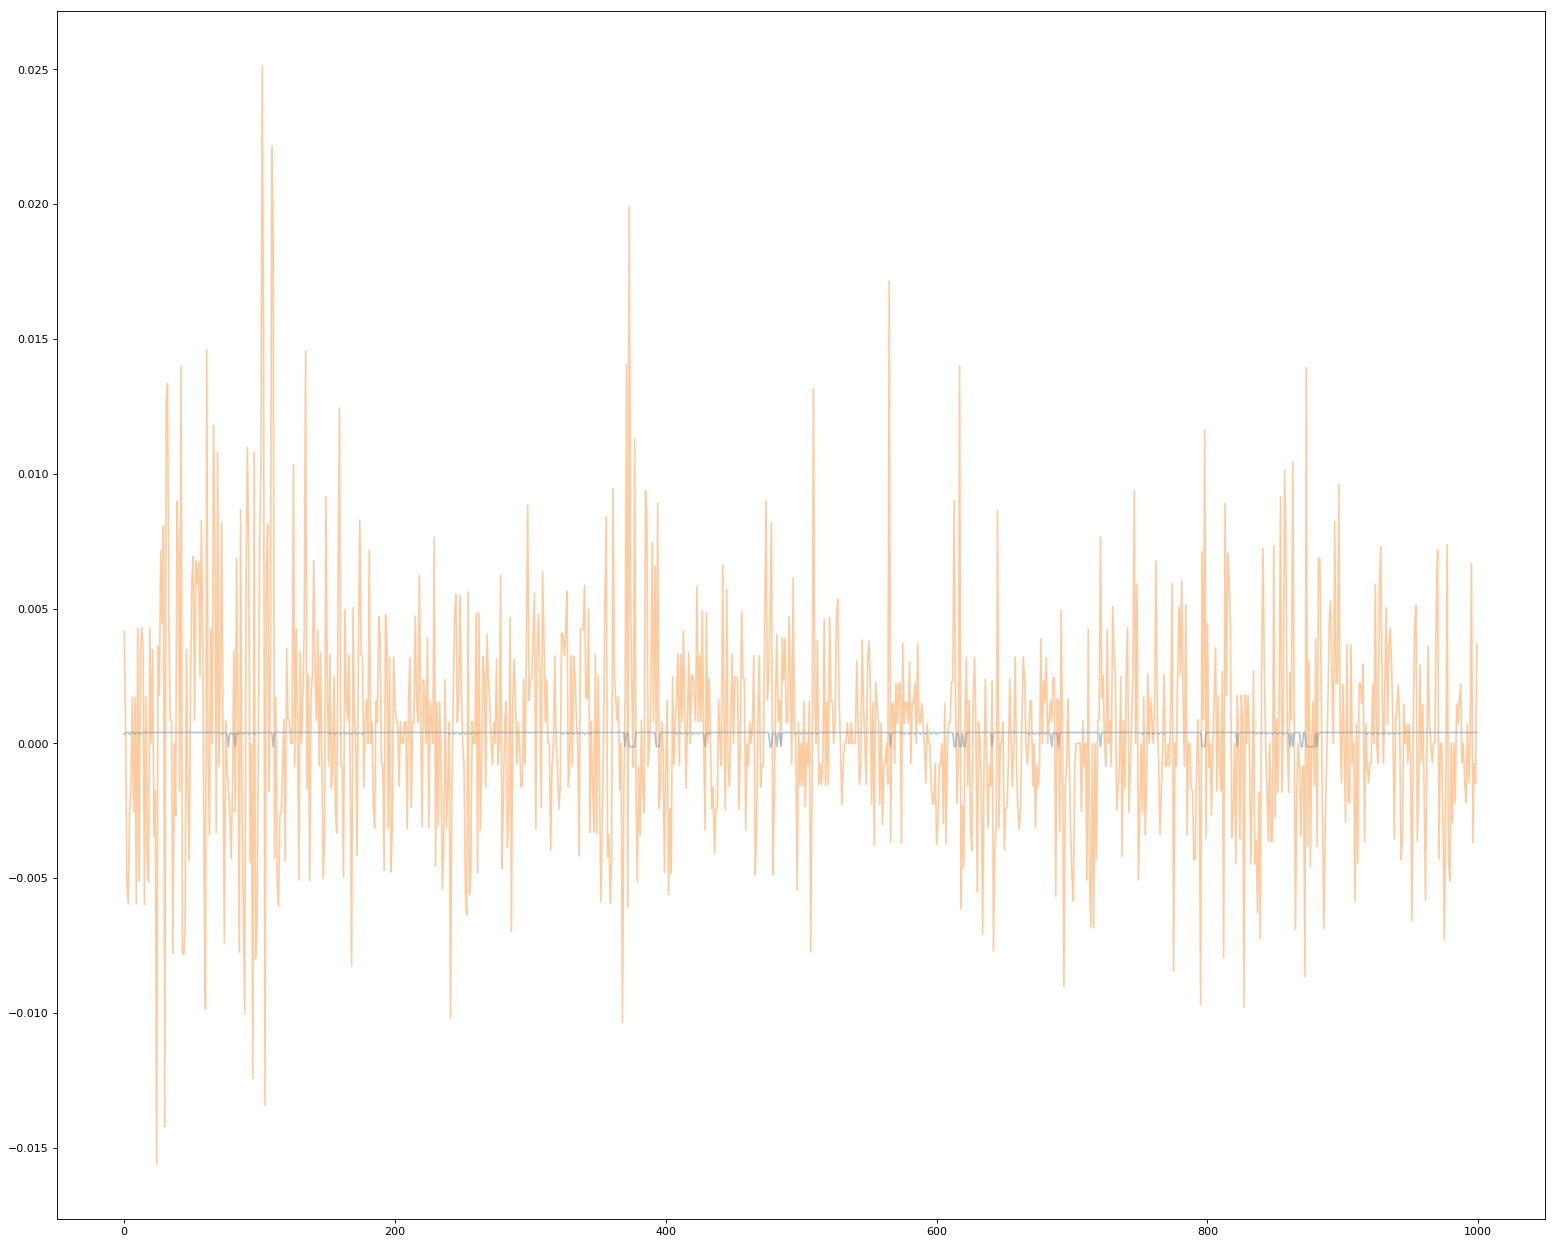

-------------------------------------------

Site Id: 1 , CV RMSE: 0.005668528935653006 




KeyboardInterrupt: 

In [28]:
#LGBM site-wise model

from tqdm.autonotebook import tqdm
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit()
all_features = [col for col in df_train.columns if col not in ["datetime", 'DIFF','']]

seed = 13

cv = 3
models = {}
cv_scores = {"site_id": [], "cv_score": []}
predlist = {}
reallist = {}
bigdf = pd.DataFrame()


for index in tqdm(range(len(df_train['site_id'].drop_duplicates().values))):
    site_id = df_train['site_id'].drop_duplicates().values[index]
    print(cv, "fold CV for site_id:", site_id)
    kf = KFold(n_splits=cv, random_state=seed)
    models[site_id] = []

    X_train_site = df_train[df_train.site_id==site_id].drop(columns = ['timestamp']).reset_index(drop=True)
    y_train_site = X_train_site.DIFF
    
    X_train_site, X_site_test, y_train_site, y_site_test = train_test_split( X_train_site, y_train_site, shuffle=False, test_size=0.2)
    print('Train Test loaded, shape and head')
    print(X_train_site.shape, X_site_test.shape)
    print(X_train_site.head(10),X_site_test.head(10))
    y_pred_train_site = np.zeros(X_train_site.shape[0])

    score = 0

    for fold, (train_index, valid_index) in enumerate(tscv.split(X_train_site, y_train_site)):
        print('indexs are',train_index,valid_index)
        X_train, X_valid = X_train_site.loc[train_index, all_features], X_train_site.loc[valid_index, all_features]
        y_train, y_valid = y_train_site.iloc[train_index], y_train_site.iloc[valid_index]
        
        dtrain = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
        dvalid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=categorical_features)

        watchlist = [dtrain, dvalid]

        params = {"objective": "regression",
                  "num_leaves": 31,
                  "learning_rate": 0.15,
                  "bagging_fraction": 0.93,
                  "feature_fraction": 0.87,
                  "metric": "rmse"
                  }

        model_lgb = lgb.train(params, train_set=dtrain, num_boost_round=2300, valid_sets=watchlist, verbose_eval=101, early_stopping_rounds=101)
        models[site_id].append(model_lgb)

        y_pred_valid = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
        y_pred_train_site[valid_index] = y_pred_valid
        

        rmse = np.sqrt(mean_squared_error(y_valid, y_pred_valid))
        print("Site Id:", site_id, ", Fold:", fold+1, ", RMSE:", rmse)
        score += rmse / cv
    
        gc.collect()
     
    prediction = models[site_id][0].predict(X_site_test)
    rmse = np.sqrt(mean_squared_error(y_site_test, prediction))
    print('-------------- Test Results ---------------')
    from matplotlib.pyplot import figure
    figure(num=None, figsize=(24, 20), dpi=80, facecolor='w', edgecolor='k')
    print("Site Id:", site_id,", RMSE:", rmse)
    plt.plot(prediction[0:1000],alpha=0.4)
    plt.plot(np.array(y_site_test)[0:1000],alpha = 0.4)
    #plt.ylim(-0.002, 0.002)
    plt.show()
    print('-------------------------------------------')
    cv_scores["site_id"].append(site_id)
    cv_scores["cv_score"].append(score)
    
    
    prediction = pd.DataFrame({'pred':models[site_id][0].predict(X_site_test)})
    
    
    #print(prediction.shape,X_site_test.shape)
    predcombined = pd.concat([X_site_test.reset_index(drop=True), prediction.reset_index(drop=True)], axis=1)
    bigdf = pd.concat([bigdf.reset_index(drop=True), predcombined.reset_index(drop=True)],axis=0)
    
    #print(bigdf)
    
    for index, row in predcombined.iterrows():
        stocktime = str(int(row["year"])) + "_" + str(int(row["month"])) + "_" + str(int(row["day"])) + "_" + str(int(row["hour"]))
        #print("YYYYYY1")
        #print(stocktime)
        if stocktime in predlist.keys() and predlist[stocktime] is not None:
            #predlist[stocktime].update(predlist['stocktime'].append([row['pred'], row['ticker_le']]))
            predlist[stocktime].append([row['pred'], row["DIFF"], row['ticker_le']])
            #print("YYYYYY1a")
            #print(predlist)
        else:
            predlist[stocktime] = [[row['pred'], row["DIFF"], row['ticker_le']]]
            #print("YYYYYY1b")
            #print(predlist)
            
        if stocktime in reallist.keys() and reallist[stocktime] is not None:
            #predlist[stocktime].update(predlist['stocktime'].append([row['pred'], row['ticker_le']]))
            reallist[stocktime].append([row['DIFF'], row["pred"], row['ticker_le']])
            #print("YYYYYY1a")
            #print(predlist)
        else:
            reallist[stocktime] = [[row['DIFF'], row["pred"], row['ticker_le']]]
            #print("YYYYYY1b")
            #print(predlist)
    #print("XXXXXX")
    #pprint.pprint(predlist)
    #print(predlist)
    #print("XXXXXX")
    
    
        
    print("\nSite Id:", site_id, ", CV RMSE:", np.sqrt(mean_squared_error(y_train_site, y_pred_train_site)), "\n")

In [37]:
# save models for later use
from joblib import dump, load
#dump(models, 'lgbm_models.joblib') 
#models_loaded = load('lgbm_models.joblib') 
#models_loaded

dump(models, 'lgbm.joblib') 

['lgbm.joblib']

In [38]:
# save extracted test data for later use
dump(bigdf,'lgbm_test_data.joblib')

['lgbm_test_data.joblib']

In [ ]:
#Save, if you need it (not updated to joblib but eh)
import pickle
with open('predlist.pickle', 'wb') as handle:
    pickle.dump(predlist, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('reallist.pickle', 'wb') as handle:
    pickle.dump(reallist, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('bigdf.pickle', 'wb') as handle:
    pickle.dump(bigdf, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [85]:
# SGD regressors
reg_models = {}
from sklearn.linear_model import SGDRegressor
from tqdm.autonotebook import tqdm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV



tscv = TimeSeriesSplit()
all_features = [col for col in df_train.columns if col not in ["timestamp", 'DIFF','']]

seed = 13

cv = 3
#models = {}
cv_scores = {"site_id": [], "cv_score": []}
predlist = {}
reallist = {}
bigdf = pd.DataFrame()
#print(df_train_clf.dtypes)
df_train_clf = df_train.dropna()
#print('NAN dropped')

for index in tqdm(range(len(df_train['site_id'].drop_duplicates().values))):
    site_id = df_train_clf['site_id'].drop_duplicates().values[index]
    print(cv, "fold CV for site_id:", site_id)
    kf = KFold(n_splits=cv, random_state=seed)
    reg_models[site_id] = []

    X_train_site = df_train_clf[df_train_clf.site_id==site_id].drop(columns = ['timestamp']).reset_index(drop=True)
    y_train_site = X_train_site.DIFF
    
    X_train_site, X_site_test, y_train_site, y_site_test = train_test_split( X_train_site, y_train_site, shuffle=False, test_size=0.2)
    print('Train Test loaded, shape and head')
    print(X_train_site.shape, X_site_test.shape)
    print(X_train_site.head(10),X_site_test.head(10))
    y_pred_train_site = np.zeros(X_train_site.shape[0])

    score = 0

    for fold, (train_index, valid_index) in enumerate(tscv.split(X_train_site, y_train_site)):
        print('indexs are',train_index,valid_index)
        X_train, X_valid = X_train_site.loc[train_index, all_features], X_train_site.loc[valid_index, all_features]
        y_train, y_valid = y_train_site.iloc[train_index], y_train_site.iloc[valid_index]
        
        parameters = {
            'poly__degree' : [1,2],                             # specify the degree of the polynomial here
            'sgd__alpha'   : np.logspace(-5,1,7)   # search range for parameter α
                                                   # in the sgd step of the pipeline
            #use your given name, underscore underscore para name
        }
        

        pipeline = Pipeline([
            ('mm',   MinMaxScaler()),
            ('poly',PolynomialFeatures()),
            ('sgd',  SGDRegressor(penalty="l2",max_iter=1000,tol=1e-4,alpha=0,random_state=0)),
        ])
        
        grid_search = GridSearchCV(
            pipeline,                             # the ML pipeline we wish to test
            parameters,                              # all parameter settings
            scoring='neg_mean_squared_error', # the scoring metric to calculate
                                              # since this maximizes, we use -MSE
            cv=TimeSeriesSplit(n_splits=5), # how to design the folds
            # cv=5, it will randomly shuffle no longer doing timeseries 
            return_train_score=True,           # useful for debugging, calculate the trainset
            #verbose=1                              # performance
        )
        
        
        grid_search.fit(X_train,y_train)
        
        pipeline.set_params(sgd__alpha=grid_search.best_params_['sgd__alpha'], poly__degree=grid_search.best_params_['poly__degree'])
        reg = pipeline.fit(X_train,y_train)
        
        
#         dtrain = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
#         dvalid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=categorical_features)

    
        # model_clf = lgb.train(params, train_set=dtrain, num_boost_round=2300, valid_sets=watchlist, verbose_eval=101, early_stopping_rounds=101)
        reg_models[site_id].append(reg)
        
    
        y_pred_valid = reg.predict(X_valid)
        prediction = reg.predict(X_site_test.drop(columns=['DIFF']))
        #y_pred_valid = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
        y_pred_train_site[valid_index] = y_pred_valid
        

        rmse = np.sqrt(mean_squared_error(y_valid, y_pred_valid))
        print("Site Id:", site_id, ", Fold:", fold+1, ", RMSE:", rmse)
        score += rmse / cv
    
        gc.collect()
    
    
    
    rmse = np.sqrt(mean_squared_error(y_site_test, prediction))
    print('-------------- Test Results ---------------')
    from matplotlib.pyplot import figure
    figure(num=None, figsize=(24, 20), dpi=80, facecolor='w', edgecolor='k')
    print("Site Id:", site_id,", RMSE:", rmse)
    plt.plot(prediction[0:1000],alpha=0.4)
    plt.plot(np.array(y_site_test)[0:1000],alpha = 0.4)
    #plt.ylim(-0.002, 0.002)
    plt.show()
    print('-------------------------------------------')
    cv_scores["site_id"].append(site_id)
    cv_scores["cv_score"].append(score)
    
    
    prediction = pd.DataFrame({'pred':reg_models[site_id][0].predict(X_site_test.drop(columns = ['DIFF']))})
    
    
    #print(prediction.shape,X_site_test.shape)
    predcombined = pd.concat([X_site_test.reset_index(drop=True), prediction.reset_index(drop=True)], axis=1)
    bigdf = pd.concat([bigdf.reset_index(drop=True), predcombined.reset_index(drop=True)],axis=0)
    
    #print(bigdf)
    
    for index, row in predcombined.iterrows():
        stocktime = str(int(row["year"])) + "_" + str(int(row["month"])) + "_" + str(int(row["day"])) + "_" + str(int(row["hour"]))
        #print("YYYYYY1")
        #print(stocktime)
        if stocktime in predlist.keys() and predlist[stocktime] is not None:
            #predlist[stocktime].update(predlist['stocktime'].append([row['pred'], row['ticker_le']]))
            predlist[stocktime].append([row['pred'], row["DIFF"], row['ticker_le']])
            #print("YYYYYY1a")
            #print(predlist)
        else:
            predlist[stocktime] = [[row['pred'], row["DIFF"], row['ticker_le']]]
            #print("YYYYYY1b")
            #print(predlist)
            
        if stocktime in reallist.keys() and reallist[stocktime] is not None:
            #predlist[stocktime].update(predlist['stocktime'].append([row['pred'], row['ticker_le']]))
            reallist[stocktime].append([row['DIFF'], row["pred"], row['ticker_le']])
            #print("YYYYYY1a")
            #print(predlist)
        else:
            reallist[stocktime] = [[row['DIFF'], row["pred"], row['ticker_le']]]
            #print("YYYYYY1b")
            #print(predlist)
    #print("XXXXXX")
    #pprint.pprint(predlist)
    #print(predlist)
    #print("XXXXXX")
    
    
        
    print("\nSite Id:", site_id, ", CV RMSE:", np.sqrt(mean_squared_error(y_train_site, y_pred_train_site)), "\n")

NameError: name 'df_train' is not defined

In [102]:
#bigdf

In [ ]:
#save that test set and all models
from joblib import dump, load
#dump(models, 'lgbm_models.joblib') 
#models_loaded = load('lgbm_models.joblib') 
#models_loaded

dump(reg_models, 'SGDRegression.joblib') 
dump(bigdf,'reg_test_data.joblib')

In [ ]:
#Save, if you need it (not updated to joblib but eh)
import pickle
with open('predlist.pickle', 'wb') as handle:
    pickle.dump(predlist, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('reallist.pickle', 'wb') as handle:
    pickle.dump(reallist, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('bigdf.pickle', 'wb') as handle:
    pickle.dump(bigdf, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
del df_train
gc.collect()

In [13]:
import joblib
test_df = joblib.load('lgbm_test_data.joblib')

In [15]:
models = joblib.load('lgbm.joblib')

In [67]:
# trading simulation, total can be either 5M or 10M to experiment with
#620 days in lgbm test set 
# invest $10000 dollar in each promising ones
def yearly_interest(invest_money,test_df,confidence_level):
    #invest_money = 10000 # for each  
    total  = 10000000 # for all 
    # the long earning would be invest money * actual percent change - 2 transaction fee(in and out)
    test_df['long_earning'] =np.subtract(np.multiply(invest_money,test_df['DIFF']),np.multiply(np.divide(invest_money,test_df['close']),0.0039*4))
    test_df['short_earning'] =-np.subtract(np.multiply(invest_money,test_df['DIFF']),np.multiply(np.divide(invest_money,test_df['close']),0.0039*4))
    print('')
    test_df['invest_count'] = np.multiply(1,np.divide(test_df['DIFF'],test_df['DIFF']))
    print('transaction trigger:',confidence_level*0.0039)
    invest_long_df = test_df[test_df.pred * test_df.close > confidence_level*0.0039]
    invest_short_df = test_df[-test_df.pred*test_df.close > confidence_level*0.0039]
    # confidence level at 
#     print(invest_long_df)
#     print(invest_short_df)
    print('yearly gain rate:')
    print(invest_long_df.sum().long_earning/((total)*2),'with',int(invest_long_df.sum().invest_count),'times of investment made')
    print(invest_short_df.sum().short_earning/(total)/2,'with',int(invest_short_df.sum().invest_count),'times of investiments made')
#     print(invest_long_df)
#     print(invest_short_df)
    return invest_long_df.sum().long_earning/(total)/2*620/730, invest_short_df.sum().short_earning/(total)/2*620/730


---------- 10000 ----------

transaction trigger: 0.0
yearly gain rate:
0.09175780362869129 with 874592 times of investment made
-0.01054573744109571 with 218084 times of investiments made
total interest: 0.06897463155658803
---------- 10000 ----------

transaction trigger: 0.0039
yearly gain rate:
0.09071165607033596 with 832890 times of investment made
-0.01159087679195404 with 179384 times of investiments made
total interest: 0.0671984700720504
---------- 10000 ----------

transaction trigger: 0.0078
yearly gain rate:
0.09471433963186368 with 769200 times of investment made
-0.012652507100449503 with 160194 times of investiments made
total interest: 0.0696963509170915
---------- 10000 ----------

transaction trigger: 0.011699999999999999
yearly gain rate:
0.09884637444677129 with 688047 times of investment made
-0.012836897810943425 with 144884 times of investiments made
total interest: 0.07304914454001818
---------- 10000 ----------

transaction trigger: 0.0156
yearly gain rate:
0.

Text(0, 0.5, 'Yearly profit ratio (10000$ in each)')

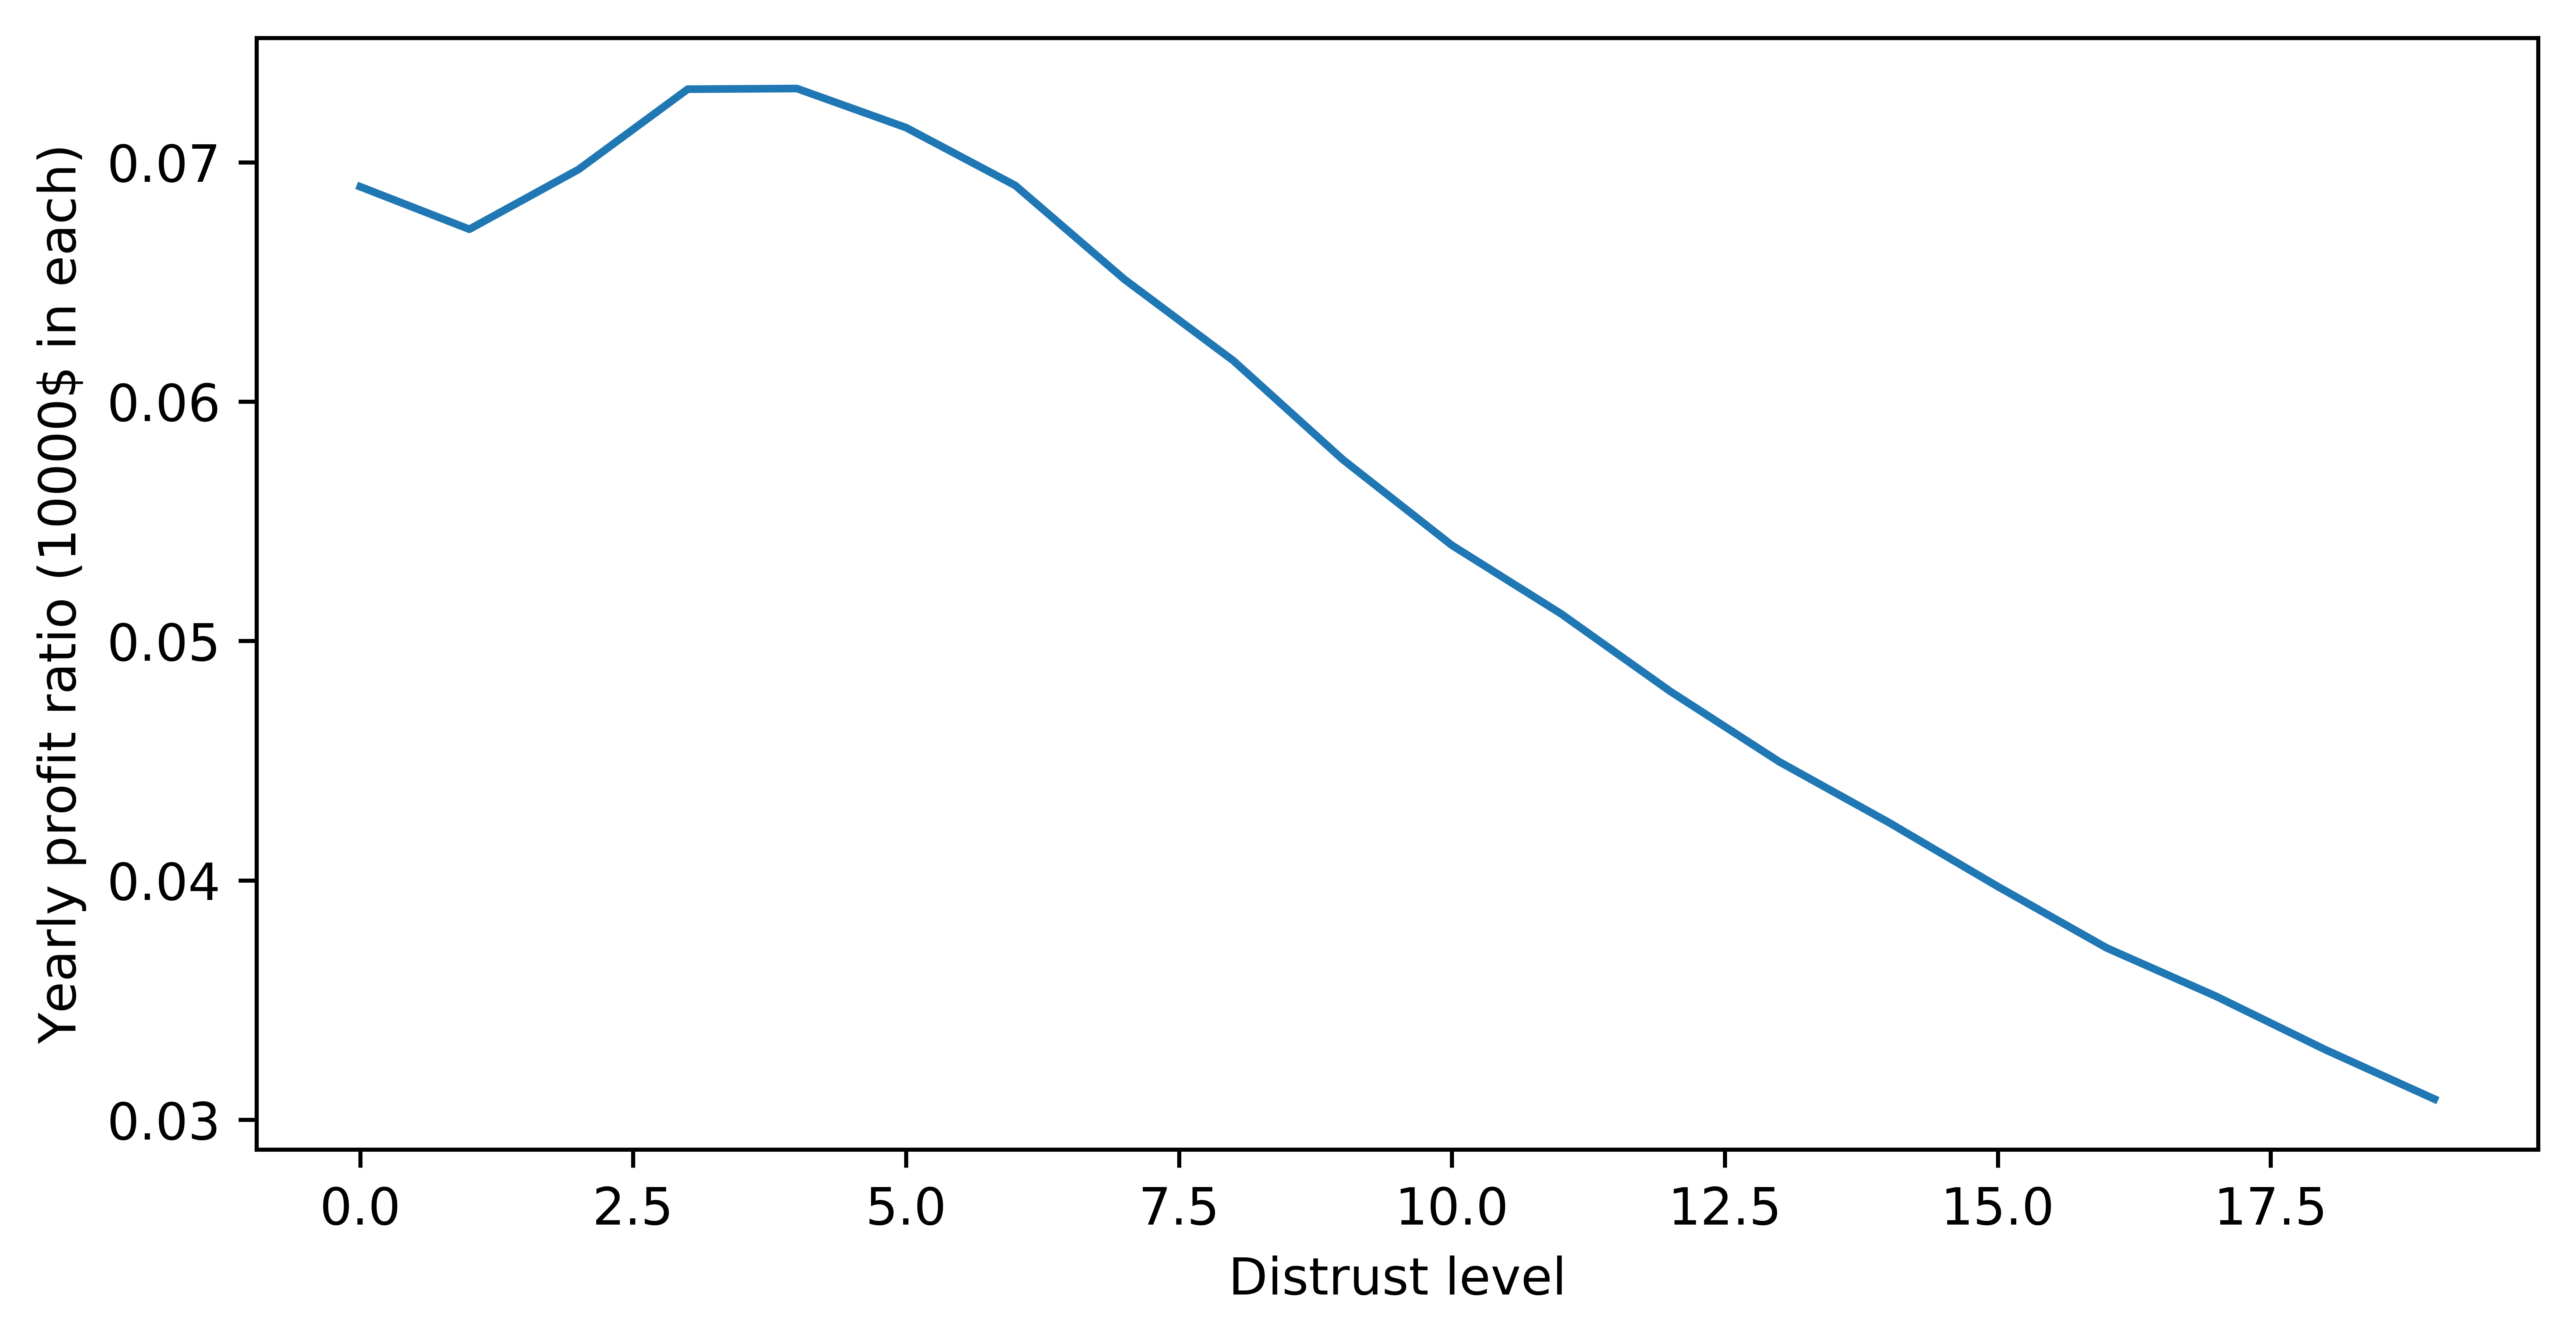

In [68]:
long_list = []
short_list = []
long_short_list = []
confi_max_list = []
for confidence in range(0,20,1):
    long_list = []
    short_list = []
    long_short_list = []
    for i in [10000]:#range(1000,10000,500):
        print("----------",i,'----------')
        long,short = yearly_interest(i,test_df,confidence)
        long_list.append(long)
        short_list.append(short)
        long_short_list.append(long+short)
        print('total interest:', long + short)
    confi_max = max(long_short_list)
    confi_max_list.append(confi_max)
    
        
# plt.plot(np.array(long_list))    
# plt.plot(np.array(short_list)) 
# plt.plot(np.array(long_short_list))
# #plt.plot(np.array(confi_max_list)) 
# plt.show()
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 4), dpi=1000, facecolor='w', edgecolor='k')
plt.plot(np.array(confi_max_list)) 
plt.xlabel('Distrust level')
plt.ylabel('Yearly profit ratio (10000$ in each)')
    

In [69]:
#620 days in lgbm test set 
# invest $10000 dollar in each promising ones
def yearly_interest(invest_money,test_df,confidence_level):
    #invest_money = 10000 # for each  
    total  = 10000000 # for all 
    # the long earning would be invest money * actual percent change - 2 transaction fee(in and out)
    test_df['long_earning'] =np.subtract(np.multiply(invest_money,test_df['DIFF']),np.multiply(np.divide(invest_money,test_df['close']),0.0039*4))
    test_df['short_earning'] =-np.subtract(np.multiply(invest_money,test_df['DIFF']),np.multiply(np.divide(invest_money,test_df['close']),0.0039*4))
    print('')
    test_df['invest_count'] = np.multiply(1,np.divide(test_df['DIFF'],test_df['DIFF']))
    print('transaction trigger:',confidence_level*0.0039)
    invest_long_df = test_df[test_df.pred * test_df.close > confidence_level*0.0039]
    invest_short_df = test_df[-test_df.pred*test_df.close > confidence_level*0.0039]
    # confidence level at 
#     print(invest_long_df)
#     print(invest_short_df)
    print('yearly gain rate:')
    print(invest_long_df.sum().long_earning/((total)*2),'with',int(invest_long_df.sum().invest_count),'times of investment made')
    print(invest_short_df.sum().short_earning/(total)/2,'with',int(invest_short_df.sum().invest_count),'times of investiments made')
#     print(invest_long_df)
#     print(invest_short_df)
    return invest_long_df.sum().long_earning/(total)/2*620/730, invest_short_df.sum().short_earning/(total)/2*620/730


In [ ]:
long_list = []
short_list = []
long_short_list = []
confi_max_list = []
invest_money = []
for confidence in range(4,5):
    long_list = []
    short_list = []
    long_short_list = []
    for i in range(1000,20000,500):
        invest_money.append(i)
        print("----------",i,'----------')
        long,short = yearly_interest(i,test_df,confidence)
        long_list.append(long)
        short_list.append(short)
        long_short_list.append(long+short)
        print('total interest:', long + short)
    confi_max = max(long_short_list)
    confi_max_list.append(confi_max)
    
        
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 4), dpi=1000, facecolor='w', edgecolor='k')
plt.plot(np.array(invest_money),np.array(long_short_list))
plt.xlabel('Evenly weighted money invested')
plt.ylabel('Yearly profit ratio')

    

---------- 1000 ----------

transaction trigger: 0.0156
yearly gain rate:
0.009878135061714217 with 628062 times of investment made
-0.0012739644559485604 with 136804 times of investiments made
total interest: 0.007307651747362613
---------- 1500 ----------

transaction trigger: 0.0156
yearly gain rate:
0.014817202567630354 with 628062 times of investment made
-0.0019109466798734852 with 136804 times of investiments made
total interest: 0.010961477603300353
---------- 2000 ----------

transaction trigger: 0.0156
yearly gain rate:
0.019756270123428434 with 628062 times of investment made
-0.002547928911897121 with 136804 times of investiments made
total interest: 0.014615303494725226
---------- 2500 ----------

transaction trigger: 0.0156
yearly gain rate:
0.02469533755287584 with 628062 times of investment made
-0.003184911118385568 with 136804 times of investiments made
total interest: 0.018269129300525985
---------- 3000 ----------

transaction trigger: 0.0156
yearly gain rate:
0.029

In [17]:
invest_df.describe()

,open,high,low,close,volume,num_of_trades,weight_avg_price,year,month,day,...,2_yr,10_yr,30_yr,ticker_le,DIFF,hour,site_id,pred,earning,total
count,155084.000,155084.0000,155084.000,155084.000,155084.000000,155084.000000,155084.000,155084.000000,155084.000000,155084.000000,...,153988.000000,153988.000000,153988.000000,155084.000000,155084.000000,155084.000000,155084.000000,155084.000000,155084.000000,137787.000000
mean,NaN,NaN,NaN,NaN,2181.639160,1309.211304,NaN,2017.284813,6.832375,15.872624,...,NaN,NaN,NaN,217.499819,0.000426,12.497421,217.499819,0.001522,4.255726,9987.117188
std,NaN,NaN,NaN,NaN,7111.650391,3443.549805,NaN,0.794909,3.382950,8.727239,...,0.000000,0.000000,0.000000,137.429751,0.004143,1.118427,137.429751,0.001573,41.456730,12.884062
min,35.000,35.0000,35.000,35.000,0.000000,0.000000,35.000,2015.000000,1.000000,1.000000,...,0.489990,1.370117,2.109375,1.000000,-0.092346,7.000000,1.000000,0.001366,-923.461914,10000.000000
25%,186.500,187.1250,186.625,186.000,359.000000,288.000000,186.500,2017.000000,4.000000,8.000000,...,1.259766,2.250000,2.800781,67.000000,-0.001402,11.000000,67.000000,0.001366,-14.019012,10000.000000
50%,226.375,227.1250,226.375,225.625,696.000000,535.000000,226.375,2017.000000,7.000000,16.000000,...,1.830078,2.490234,2.990234,226.000000,0.000537,12.000000,226.000000,0.001366,5.369186,10000.000000
75%,309.500,310.5625,309.500,308.250,1422.000000,1041.000000,309.500,2018.000000,10.000000,23.000000,...,2.560547,2.900391,3.109375,352.000000,0.002247,13.000000,352.000000,0.001366,22.468567,10000.000000
max,2212.000,2218.0000,2212.000,2208.000,328477.000000,136510.000000,2214.000,2019.000000,12.000000,31.000000,...,2.980469,3.240234,3.460938,456.000000,0.065186,19.000000,456.000000,0.079571,651.855469,10000.000000


In [51]:
test_df = joblib.load('SGDRegressiondf.joblib')

In [52]:
#620 days in lgbm test set 
# invest $10000 dollar in each promising ones
def yearly_interest(invest_money,test_df,confidence_level):
    #invest_money = 10000 # for each  
    total  = 10000000 # for all 
    # the long earning would be invest money * actual percent change - 2 transaction fee(in and out)
    test_df['long_earning'] =np.subtract(np.multiply(invest_money,test_df['DIFF']),np.multiply(np.divide(invest_money,test_df['close']),0.0039*4))
    test_df['short_earning'] =-np.subtract(np.multiply(invest_money,test_df['DIFF']),np.multiply(np.divide(invest_money,test_df['close']),0.0039*4))
    print('')
    test_df['invest_count'] = np.multiply(1,np.divide(test_df['DIFF'],test_df['DIFF']))
    print('transaction trigger:',confidence_level*0.0039)
    invest_long_df = test_df[test_df.pred * test_df.close > confidence_level*0.0039]
    invest_short_df = test_df[-test_df.pred*test_df.close > confidence_level*0.0039]
#     print(invest_long_df)
#     print(invest_short_df)
    print('yearly gain rate:')
    print(invest_long_df.sum().long_earning/((total)*2),'with',int(invest_long_df.sum().invest_count),'times of investment made')
    print(invest_short_df.sum().short_earning/(total)/2,'with',int(invest_short_df.sum().invest_count),'times of investiments made')
#     print(invest_long_df)
#     print(invest_short_df)
    return invest_long_df.sum().long_earning/(total)/2*620/730, invest_short_df.sum().short_earning/(total)/2*620/730


---------- 10000 ----------

transaction trigger: 0.0
yearly gain rate:
0.0482030061190594 with 455755 times of investment made
-0.008241108156616613 with 238075 times of investiments made
total interest: 0.03394024210508839
---------- 10000 ----------

transaction trigger: 0.0039
yearly gain rate:
0.05007934412200935 with 436833 times of investment made
-0.010251567444625125 with 223299 times of investiments made
total interest: 0.03382633087668249
---------- 10000 ----------

transaction trigger: 0.0078
yearly gain rate:
0.05195517901048995 with 411766 times of investment made
-0.011477328486515209 with 212057 times of investiments made
total interest: 0.03437844839022513
---------- 10000 ----------

transaction trigger: 0.011699999999999999
yearly gain rate:
0.05238242529435344 with 382265 times of investment made
-0.011819051369957253 with 202640 times of investiments made
total interest: 0.03445108470291183
---------- 10000 ----------

transaction trigger: 0.0156
yearly gain rate:

Text(0, 0.5, 'Yearly profit ratio (10000$ in each)')

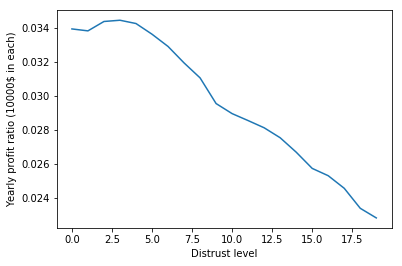

In [53]:
long_list = []
short_list = []
long_short_list = []
confi_max_list = []
for confidence in range(0,20,1):
    long_list = []
    short_list = []
    long_short_list = []
    for i in [10000]:#range(1000,10000,500):
        print("----------",i,'----------')
        long,short = yearly_interest(i,test_df,confidence)
        long_list.append(long)
        short_list.append(short)
        long_short_list.append(long+short)
        print('total interest:', long + short)
    confi_max = max(long_short_list)
    confi_max_list.append(confi_max)
    
        
# plt.plot(np.array(long_list))    
# plt.plot(np.array(short_list)) 
# plt.plot(np.array(long_short_list))
# #plt.plot(np.array(confi_max_list)) 
# plt.show()
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 4), dpi=1000, facecolor='w', edgecolor='k')
plt.plot(np.array(confi_max_list)) 
plt.xlabel('Distrust level')
plt.ylabel('Yearly profit ratio (10000$ in each)')
    

In [54]:
#620 days in lgbm test set 
# invest $10000 dollar in each promising ones
def yearly_interest(invest_money,test_df,confidence_level):
    #invest_money = 10000 # for each  
    total  = 10000000 # for all 
    # the long earning would be invest money * actual percent change - 2 transaction fee(in and out)
    test_df['long_earning'] =np.subtract(np.multiply(invest_money,test_df['DIFF']),np.multiply(np.divide(invest_money,test_df['close']),0.0039*4))
    test_df['short_earning'] =-np.subtract(np.multiply(invest_money,test_df['DIFF']),np.multiply(np.divide(invest_money,test_df['close']),0.0039*4))
    print('')
    test_df['invest_count'] = np.multiply(1,np.divide(test_df['DIFF'],test_df['DIFF']))
    print('transaction trigger:',confidence_level*0.0039)
    invest_long_df = test_df[test_df.pred * test_df.close > confidence_level*0.0039]
    invest_short_df = test_df[-test_df.pred*test_df.close > confidence_level*0.0039]
    # confidence level at 
#     print(invest_long_df)
#     print(invest_short_df)
    print('yearly gain rate:')
    print(invest_long_df.sum().long_earning/((total)*2),'with',int(invest_long_df.sum().invest_count),'times of investment made')
    print(invest_short_df.sum().short_earning/(total)/2,'with',int(invest_short_df.sum().invest_count),'times of investiments made')
#     print(invest_long_df)
#     print(invest_short_df)
    return invest_long_df.sum().long_earning/(total)/2*620/730, invest_short_df.sum().short_earning/(total)/2*620/730


In [55]:
long_list = []
short_list = []
long_short_list = []
confi_max_list = []
invest_money = []
for confidence in range(4,5):
    long_list = []
    short_list = []
    long_short_list = []
    for i in range(1000,20000,500):
        invest_money.append(i)
        print("----------",i,'----------')
        long,short = yearly_interest(i,test_df,confidence)
        long_list.append(long)
        short_list.append(short)
        long_short_list.append(long+short)
        print('total interest:', long + short)
    confi_max = max(long_short_list)
    confi_max_list.append(confi_max)
    
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 4), dpi=1000, facecolor='w', edgecolor='k')        

plt.plot(np.array(invest_money),np.array(long_short_list))
plt.xlabel('Evenly weighted money invested')
plt.ylabel('Yearly profit ratio')

    

---------- 1000 ----------

transaction trigger: 0.0156
yearly gain rate:
0.005259039642411075 with 360207 times of investment made
-0.0012254552203275729 with 194533 times of investiments made
total interest: 0.0034257840297147553
---------- 1500 ----------

transaction trigger: 0.0156
yearly gain rate:
0.007888559445435041 with 360207 times of investment made
-0.0018381828204259742 with 194533 times of investiments made
total interest: 0.005138676037678934
---------- 2000 ----------

transaction trigger: 0.0156
yearly gain rate:
0.01051807928482215 with 360207 times of investment made
-0.0024509104406551458 with 194533 times of investiments made
total interest: 0.0068515680594295105
---------- 2500 ----------

transaction trigger: 0.0156
yearly gain rate:
0.013147599026205856 with 360207 times of investment made
-0.0030636380280352196 with 194533 times of investiments made
total interest: 0.008564460025843556
---------- 3000 ----------

transaction trigger: 0.0156
yearly gain rate:
0

KeyboardInterrupt: 

In [ ]:
# Below we are trying to blend models

In [52]:
import joblib
test_df1 = joblib.load('SGDRegressiondf.joblib')
test_df2 = joblib.load('lgbm_test_data.joblib')
test_df1['pred_1'] = test_df1['pred']
test_df2['pred_2'] = test_df2['pred']
test_df1 = test_df1.dropna()
test_df2 = test_df2.dropna()
print(test_df1.shape,test_df2.shape)

(787777, 21) (1222861, 21)


In [53]:
test_df1.columns

Index(['open', 'high', 'low', 'close', 'volume', 'num_of_trades',
       'weight_avg_price', 'year', 'month', 'day', 'raw_oil', 'post_oil',
       '2_yr', '10_yr', '30_yr', 'ticker_le', 'DIFF', 'hour', 'site_id',
       'pred', 'pred_1'],
      dtype='object')

In [54]:
test_df2.columns

Index(['open', 'high', 'low', 'close', 'volume', 'num_of_trades',
       'weight_avg_price', 'year', 'month', 'day', 'raw_oil', 'post_oil',
       '2_yr', '10_yr', '30_yr', 'ticker_le', 'DIFF', 'hour', 'site_id',
       'pred', 'pred_2'],
      dtype='object')

In [55]:
test_df1 = test_df1.merge(test_df2, on=['year','month','day','ticker_le','open','high','low','close'], how="inner")

In [56]:
test_df = test_df1

In [57]:
blend = pd.DataFrame({'pred':np.add(np.multiply(test_df['pred_1'],0.2),np.multiply(test_df['pred_2'],0.8))})

In [58]:
test_df = pd.concat([blend,test_df],axis=1)
test_df

,pred,open,high,low,close,volume_x,num_of_trades_x,weight_avg_price_x,year,month,...,raw_oil_y,post_oil_y,2_yr_y,10_yr_y,30_yr_y,DIFF_y,hour_y,site_id_y,pred_y,pred_2
0,0.000918,155.250,155.750,155.250,155.125,772.0,571.0,155.375,2017,3,...,52.62500,55.09375,1.320312,2.490234,3.089844,0.000806,12,1,0.000880,0.000880
1,0.000550,155.250,155.875,155.625,155.250,556.0,464.0,155.500,2017,3,...,52.62500,55.09375,1.320312,2.490234,3.089844,-0.006443,13,1,0.000422,0.000422
2,0.000516,155.625,155.625,154.750,154.250,1282.0,904.0,154.875,2017,3,...,52.62500,55.09375,1.320312,2.490234,3.089844,0.002432,14,1,0.000382,0.000382
3,0.000920,155.375,155.500,155.250,155.000,840.0,725.0,155.250,2017,3,...,53.34375,55.90625,1.320312,2.490234,3.080078,-0.000806,11,1,0.000880,0.000880
4,0.000918,155.250,155.375,155.000,154.875,794.0,715.0,155.125,2017,3,...,53.34375,55.90625,1.320312,2.490234,3.080078,0.000000,12,1,0.000880,0.000880
5,0.000607,155.000,155.250,155.250,154.875,1011.0,906.0,155.000,2017,3,...,53.34375,55.90625,1.320312,2.490234,3.080078,-0.003229,13,1,0.000493,0.000493
6,0.000540,155.125,155.250,154.625,154.375,921.0,739.0,154.875,2017,3,...,53.34375,55.90625,1.320312,2.490234,3.080078,0.000810,14,1,0.000412,0.000412
7,0.000920,153.750,154.750,153.375,153.375,698.0,553.0,154.000,2017,3,...,53.18750,56.00000,1.309570,2.490234,3.099609,-0.008965,11,1,0.000880,0.000880
8,0.000369,153.375,153.625,152.000,152.000,1491.0,1208.0,152.625,2017,3,...,53.18750,56.00000,1.309570,2.490234,3.099609,0.000000,12,1,0.000194,0.000194
9,0.000606,152.000,152.500,152.250,152.000,1160.0,965.0,152.250,2017,3,...,53.18750,56.00000,1.309570,2.490234,3.099609,0.001645,13,1,0.000493,0.000493


In [47]:
test_df = test_df.dropna()

In [59]:
# 394 days in lgbm test set 
# invest $10000 dollar in each promising ones
def yearly_interest(invest_money,test_df,confidence_level):
    #invest_money = 10000 # for each  
    total  = 10000000 # for all 
    # the long earning would be invest money * actual percent change - 2 transaction fee(in and out)
    test_df['long_earning'] =np.subtract(np.multiply(invest_money,test_df['DIFF_x']),np.multiply(np.divide(invest_money,test_df['close']),0.0039*4))
    test_df['short_earning'] =-np.subtract(np.multiply(invest_money,test_df['DIFF_x']),np.multiply(np.divide(invest_money,test_df['close']),0.0039*4))
    print('')
    test_df['invest_count'] = np.multiply(1,np.divide(test_df['DIFF_x'],test_df['DIFF_x']))
    print('transaction trigger:',confidence_level*0.0039)
    invest_long_df = test_df[test_df.pred * test_df.close > confidence_level*0.0039]
    invest_short_df = test_df[-test_df.pred*test_df.close > confidence_level*0.0039]
    # confidence level at 
#     print(invest_long_df)
#     print(invest_short_df)
    print('yearly gain rate:')
    print(invest_long_df.sum().long_earning/((total)*1.6),'with',int(invest_long_df.sum().invest_count),'times of investment made')
    print(invest_short_df.sum().short_earning/(total)/1.6,'with',int(invest_short_df.sum().invest_count),'times of investiments made')
#     print(invest_long_df)
#     print(invest_short_df)
    return invest_long_df.sum().long_earning/(total)/2*394/730, invest_short_df.sum().short_earning/(total)/2*620/730


---------- 1000 ----------

transaction trigger: 0.0156
yearly gain rate:
0.0078011201814606615 with 379032 times of investment made
-0.0008878171141913044 with 117851 times of investiments made
total interest: 0.0027651449213116626
---------- 1500 ----------

transaction trigger: 0.0156
yearly gain rate:
0.01170168025159504 with 379032 times of investment made
-0.001331725665446429 with 117851 times of investiments made
total interest: 0.0041477173770429155
---------- 2000 ----------

transaction trigger: 0.0156
yearly gain rate:
0.015602240362921323 with 379032 times of investment made
-0.0017756342283826087 with 117851 times of investiments made
total interest: 0.005530289842623325
---------- 2500 ----------

transaction trigger: 0.0156
yearly gain rate:
0.019502800369126723 with 379032 times of investment made
-0.0022195427629344627 with 117851 times of investiments made
total interest: 0.006912862282100341
---------- 3000 ----------

transaction trigger: 0.0156
yearly gain rate:
0

Text(0, 0.5, 'Yearly profit ratio')

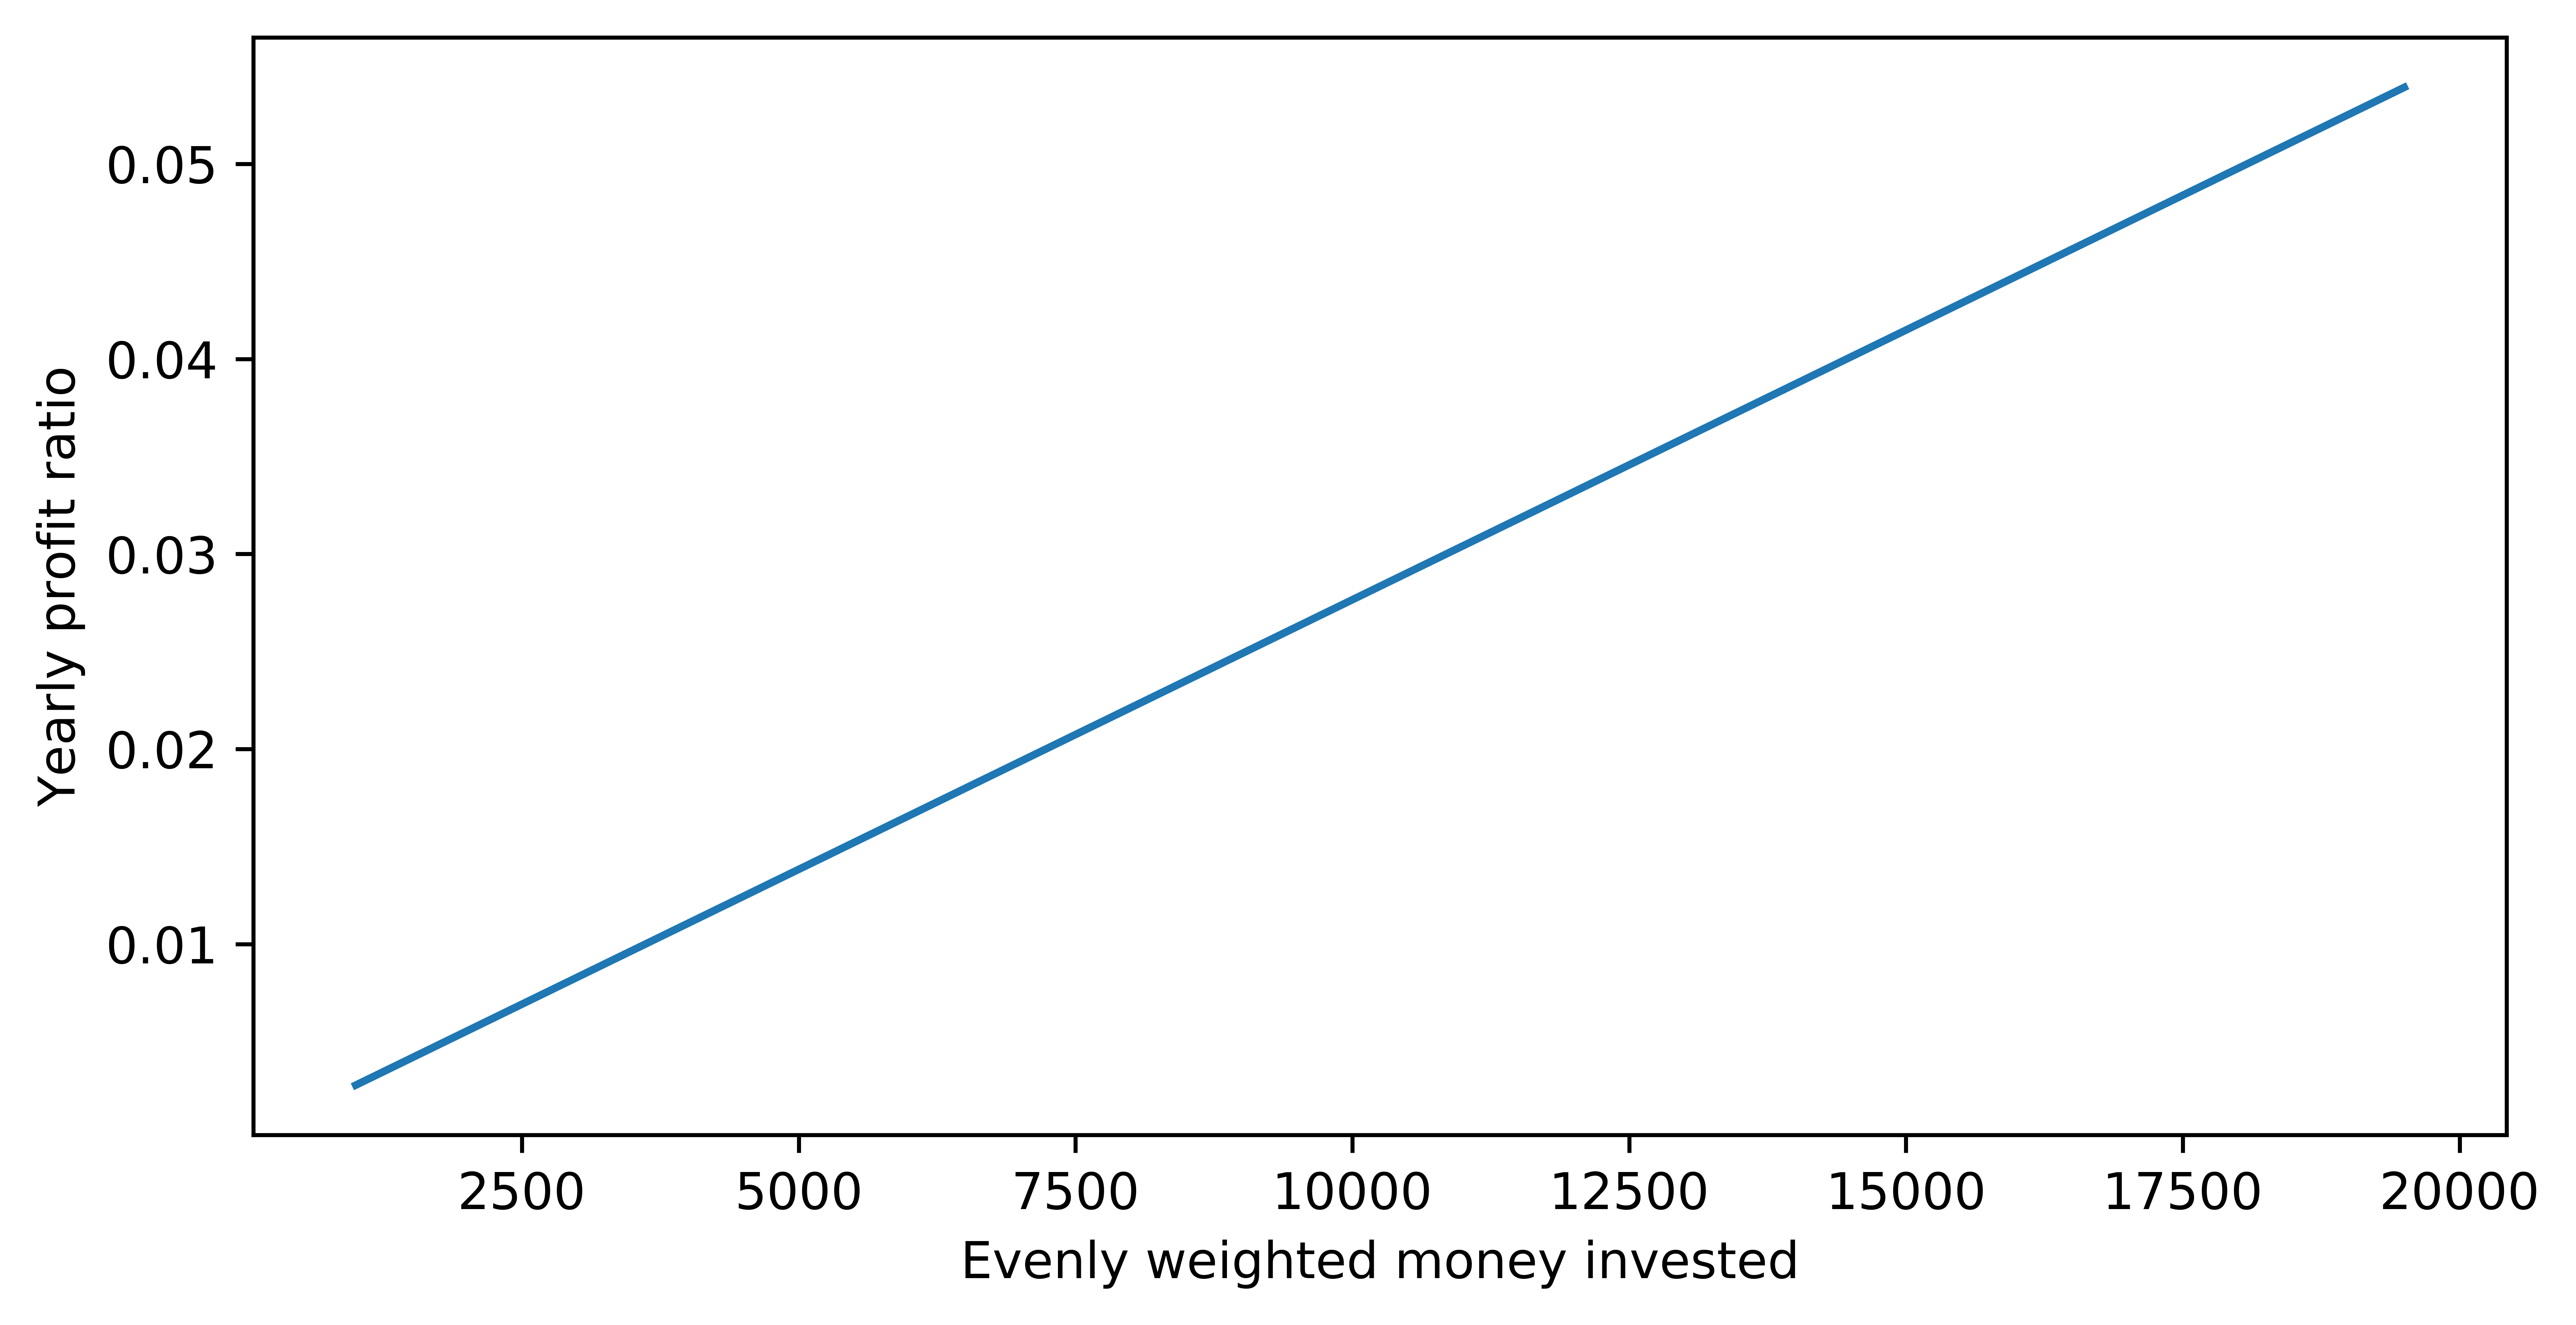

In [61]:
long_list = []
short_list = []
long_short_list = []
confi_max_list = []
invest_money = []
for confidence in range(4,5):
    long_list = []
    short_list = []
    long_short_list = []
    for i in range(1000,20000,500):
        invest_money.append(i)
        print("----------",i,'----------')
        long,short = yearly_interest(i,test_df,confidence)
        long_list.append(long)
        short_list.append(short)
        long_short_list.append(long+short)
        print('total interest:', long + short)
    confi_max = max(long_short_list)
    confi_max_list.append(confi_max)
    
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 4), dpi=1000, facecolor='w', edgecolor='k')        

plt.plot(np.array(invest_money),np.array(long_short_list))
plt.xlabel('Evenly weighted money invested')
plt.ylabel('Yearly profit ratio')

    

---------- 10000 ----------

transaction trigger: 0.0
yearly gain rate:
0.06461366795026512 with 517830 times of investment made
-0.005451122274567372 with 175921 times of investiments made
total interest: 0.02419516642429883
---------- 10000 ----------

transaction trigger: 0.0039
yearly gain rate:
0.0674676958203204 with 492716 times of investment made
-0.006874406890264711 with 156313 times of investiments made
total interest: 0.02446042726711465
---------- 10000 ----------

transaction trigger: 0.0078
yearly gain rate:
0.07416778116556444 with 449801 times of investment made
-0.00862690596817527 with 138938 times of investiments made
total interest: 0.026162656524891744
---------- 10000 ----------

transaction trigger: 0.011699999999999999
yearly gain rate:
0.07731025226777047 with 413046 times of investment made
-0.008872883611769414 with 126642 times of investiments made
total interest: 0.027352385264881672
---------- 10000 ----------

transaction trigger: 0.0156
yearly gain rate

Text(0, 0.5, 'Yearly profit ratio (10000$ in each)')

<Figure size 8000x4000 with 0 Axes>

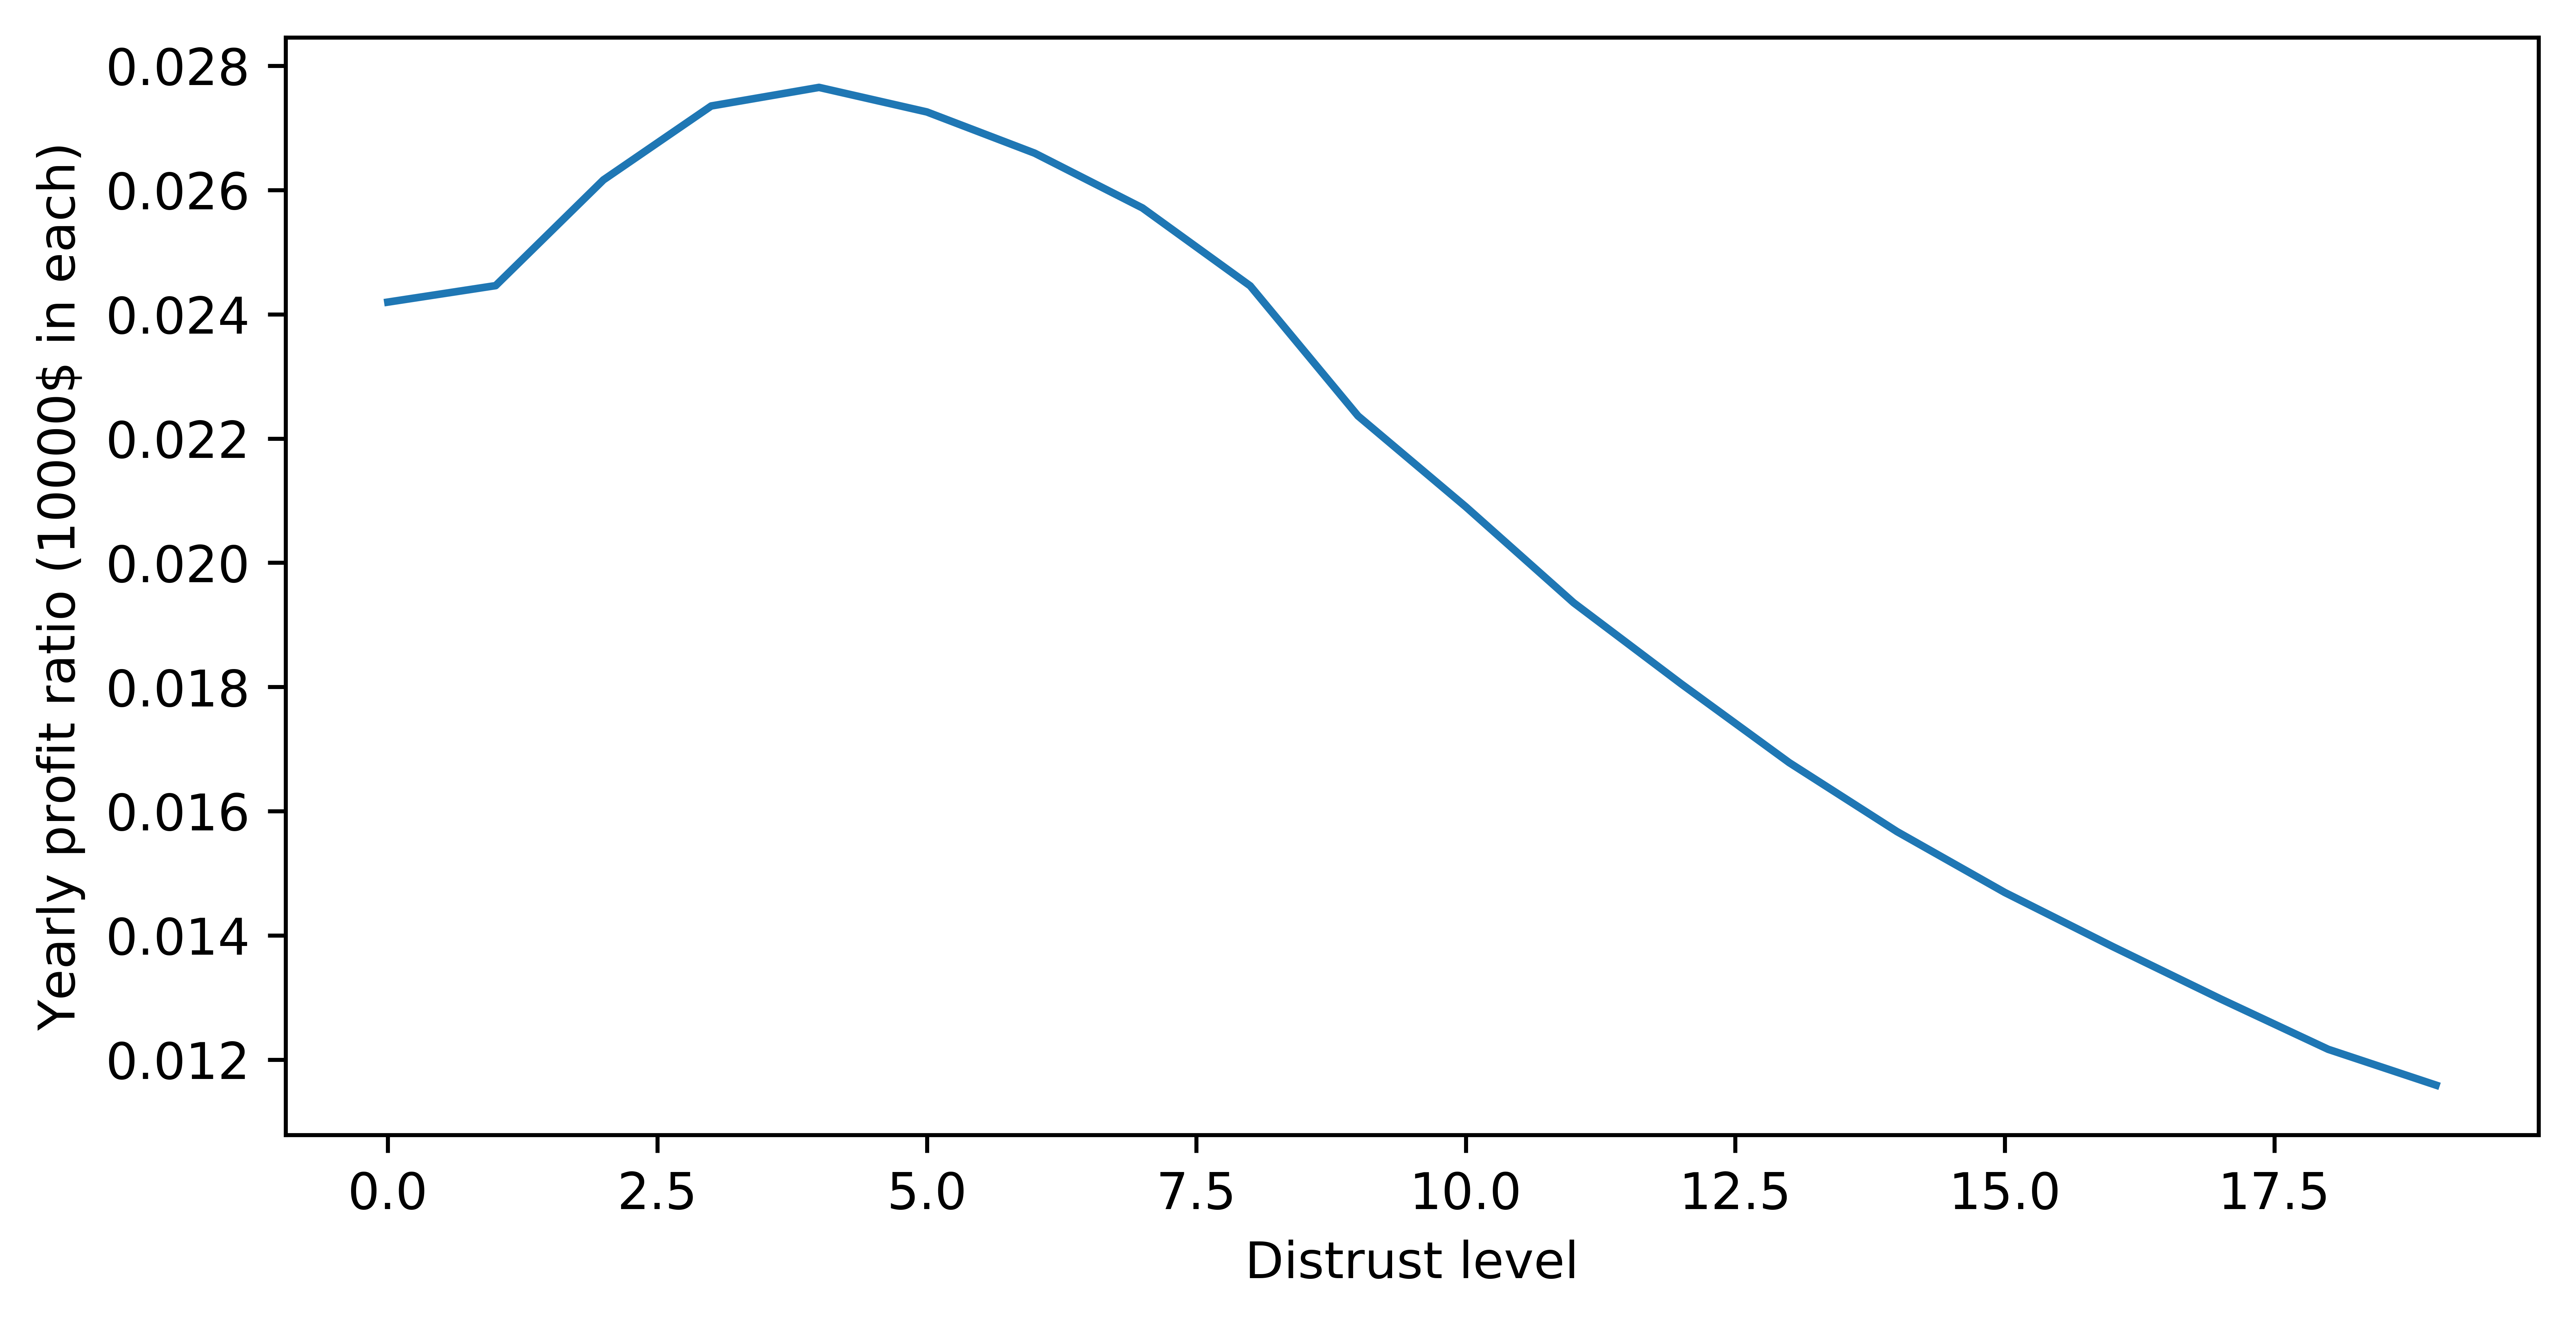

In [63]:
from matplotlib.pyplot import figure
long_list = []
short_list = []
long_short_list = []
confi_max_list = []
invest_money = []
for confidence in range(0,20):
    long_list = []
    short_list = []
    long_short_list = []
    for i in  range(10000,10001): #range(1000,20000,500):
        invest_money.append(i)
        print("----------",i,'----------')
        long,short = yearly_interest(i,test_df,confidence)
        long_list.append(long)
        short_list.append(short)
        long_short_list.append(long+short)
        print('total interest:', long + short)
    confi_max = max(long_short_list)
    confi_max_list.append(confi_max)
    
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 4), dpi=1000, facecolor='w', edgecolor='k')        




figure(num=None, figsize=(8, 4), dpi=1000, facecolor='w', edgecolor='k')
plt.plot(np.array(confi_max_list)) 
plt.xlabel('Distrust level')
plt.ylabel('Yearly profit ratio (10000$ in each)')

In [ ]:
# Blended but the results are not good so might prefer single LGBM